In [1]:
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import itertools
from typing import Union, Optional
import matplotlib.pylab as plt
import numpy as np
import networkx as nx
from adjustText import adjust_text
from cinnabar import plotlying, stats
import glob
import numpy as np
import warnings
import cinnabar
from cinnabar.classification_metric import compute_fraction_best_ligands

In [2]:
def _get_statistics(
    x: np.ndarray,
    y: np.ndarray,
    xerr: Optional[np.ndarray] = None,
    yerr: Optional[np.ndarray] = None,
    statistics: list = ["RMSE", "MUE"],
    bootstrap_x_uncertainty: bool = False,
    bootstrap_y_uncertainty: bool = False,
    statistic_type: str = "mle",
):
    statistics_out = {}
    for statistic in statistics:
        s = stats.bootstrap_statistic(x,
                                      y,
                                      xerr,
                                      yerr,
                                      statistic=statistic,
                                      include_true_uncertainty=bootstrap_x_uncertainty,
                                      include_pred_uncertainty=bootstrap_y_uncertainty)
        statistics_out[statistic] = s[statistic_type]
        statistics_out[f'{statistic}_low'] = abs(s[statistic_type] - s['low'])
        statistics_out[f'{statistic}_high'] = abs(s[statistic_type] - s['high'])
    return statistics_out

In [3]:
def _get_subset_dataframe(df, column_name, value):
    df_sub = df[df[column_name] == value]
    df_sub.reset_index(inplace=True, drop=True)
    return df_sub

In [4]:
def _get_statistics_dict(
    df: pd.DataFrame,
    statistics: list[str] = ["RAE", "RMSE", "MUE", "R2", "rho", "KTAU"],
    min_dynamic_range: int = 3,
    min_number_ligands: int = 16,
):
    """
    Function to calculate statistics for all datasets.
    Only calculating statistics for appropriately large systems
    According to Hahn et al. systems with a minimum dynamic range of 3 kcal/mol
    and a minimum of 16 ligands (https://doi.org/10.33011/livecoms.4.1.1497)

    Parameters
    ----------
    df: pd.DataFrame
      DataFrame including data
    statistics: list[str]
      Statistics to calculate for the datasets
    min_dynamic_range: int
      minimum dynamic range (in kcal/mol)
    min_number_ligands: int
      minimum number of ligands per dataset

    Returns
    -------
    all_stats: dict[str, dict[str, dict[str, float]]]
      Results dictionary of the different sets and individual datasets within each set.
      Contains the name of the static and a list of the value for that statistic,
      the lower, and the upper confidence interval.

    """

    all_stats = {}
    for s in df['system group'].unique():
        df_s = _get_subset_dataframe(df, 'system group', s)
        stats_dict = {}
        for t in df_s['system name'].unique():
            df_t = _get_subset_dataframe(df_s, 'system name', t)
    
            # Calculate the dynamic range of the dataset
            dynamic_range = abs(max(df_t['Exp DG (kcal/mol)']) - min(df_t['Exp DG (kcal/mol)']))
        
            # Do not calculate statics for systems with few ligands (specified in min_number_ligands)
            # or a small dynamic range (specified in min_dynamic_range)
            if dynamic_range < min_dynamic_range or len(df_t) < min_number_ligands:
                continue
    
            # Store statistics including the lower and higher 95% confidence interval        
            stats_out = _get_statistics(
                df_t['Exp DG (kcal/mol)'], 
                df_t['DG (kcal/mol)'], 
                df_t['Exp dDG (kcal/mol)'], 
                df_t['uncertainty (kcal/mol)'],
                statistics=statistics,
            )
            fbl = compute_fraction_best_ligands(df_t['Exp DG (kcal/mol)'],df_t['DG (kcal/mol)'], fraction=0.5)
            stats_out["FBL"] = fbl
            stats_dict[t] = stats_out 
        if stats_dict:
            all_stats[s] = stats_dict

    return all_stats

In [5]:
def _master_plot(
    x: np.ndarray,
    y: np.ndarray,
    title: str = "",
    xerr: Optional[np.ndarray] = None,
    yerr: Optional[np.ndarray] = None,
    method_name: str = "",
    target_name: str = "",
    quantity: str = r"$\Delta$ G",
    xlabel: str = "Experimental",
    ylabel: str = "Calculated",
    units: str = r"$\mathrm{kcal\,mol^{-1}}$",
    guidelines: bool = True,
    origins: bool = False,
    color: Optional[str] = None,
    statistics: list = ["RMSE", "MUE"],
    filename: Optional[str] = None,
    centralizing: bool = True,
    shift: float = 0.0,
    figsize: float = 5,
    dpi: Union[float, str] = 300,
    data_labels: list = [],
    axis_padding: float = 0.5,
    xy_lim: list = [],
    font_sizes: dict = {"title": 12, "labels": 9, "other": 12},
    bootstrap_x_uncertainty: bool = False,
    bootstrap_y_uncertainty: bool = False,
    statistic_type: str = "mle",
    scatter_kwargs: dict = {"s": 20, "marker": "o"},
):
    """Handles the aesthetics of the plots in one place.

    Parameters
    ----------
    x : np.ndarray
        Values to plot on the x axis
    y : np.ndarray
        Values to plot on the y axis
    title : string, default = ''
        Title for the plot
    xerr : np.ndarray , default = None
        Error bars for x values
    yerr : np.ndarray , default = None
        Error bars for y values
    method_name : string, optional
        name of method associated with results, e.g. 'perses'
    target_name : string, optional
        name of system for results, e.g. 'Thrombin'
    quantity : str, default = '$\Delta \Delta$ G'
        metric that is being plotted
    xlabel : str, default = 'Experimental'
        label for xaxis
    ylabel : str, default = 'Calculated'
        label for yaxis
    units : str, default = r'$\mathrm{kcal\,mol^{-1}}$'
        string value of units to label axis
    guidelines : bool, default = True
        toggles plotting of grey 0.5 and 1 kcal/mol error zone
    origins : bool, default = False
        toggles plotting of x and y axis
    color : str, default = None
        if None, will be coloured according to distance from unity
    statistics : list(str), default = ['RMSE',  'MUE']
        list of statistics to calculate and report on the plot
    filename : str, default = None
        filename for plot
    centralizing : bool, default = True
        ofset the free energies
    shift : float, default = 0.
        shift both the x and y axis by a constant
    figsize : float, default = 5
        size of figure for matplotlib
    dpi : float or 'figure', default '300'
        the resolution in dots per inch
        if 'figure', uses the figure's dpi value (this behavior is copied from
        https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html)
    data_labels : list of str, default []
        list of labels for each data point
    axis_padding : float, default = 0.5
        padding to add to maximum axis value and subtract from the minimum axis value
    xy_lim : list, default []
        contains the minimium and maximum values to use for the x and y axes. if specified, axis_padding is ignored
    font_sizes : dict, default {"title": 12, "labels": 9, "other": 12}
        font sizes to use for the title ("title"), the data labels ("labels"), and the rest of the plot ("other")
    bootstrap_x_uncertainty : bool, default False
        whether to account for uncertainty in x when bootstrapping
    bootstrap_y_uncertainty : bool, default False
        whether to account for uncertainty in y when bootstrapping
    statistic_type : str, default 'mle'
        the type of statistic to use, either 'mle' (i.e. sample statistic)
        or 'mean' (i.e. bootstrapped mean statistic)
    scatter_kwargs : dict, default {"s": 20, "marker": "o"}
        arguments to control plt.scatter()

    Returns
    -------

    """
    nsamples = len(x)
    # aesthetics
    plt.rcParams["xtick.labelsize"] = font_sizes["other"]
    plt.rcParams["ytick.labelsize"] = font_sizes["other"]
    plt.rcParams["font.size"] = font_sizes["other"]

    fig = plt.figure(figsize=(figsize, figsize))
    plt.subplots_adjust(left=0.2, right=0.8, bottom=0.2, top=0.8)

    plt.xlabel(f"{xlabel} {quantity} ({units})")
    plt.ylabel(f"{ylabel} {quantity} ({units})")

    if xy_lim:
        ax_min, ax_max = xy_lim
        scale = xy_lim
    else:
        ax_min = min(min(x), min(y)) - axis_padding
        ax_max = max(max(x), max(y)) + axis_padding
        scale = [ax_min, ax_max]

    plt.xlim(scale)
    plt.ylim(scale)

    # plots x-axis and y-axis
    if origins:
        plt.plot([0, 0], scale, "gray")
        plt.plot(scale, [0, 0], "gray")

    # plots x=y line
    plt.plot(scale, scale, "k:")
    if guidelines:
        small_dist = 0.5
        # plots grey region around x=y line
        plt.fill_between(
            scale,
            [ax_min - small_dist, ax_max - small_dist],
            [ax_min + small_dist, ax_max + small_dist],
            color="grey",
            alpha=0.2,
        )
        plt.fill_between(
            scale,
            [ax_min - small_dist * 2, ax_max - small_dist * 2],
            [ax_min + small_dist * 2, ax_max + small_dist * 2],
            color="grey",
            alpha=0.2,
        )
    # actual plotting
    cm = plt.get_cmap("coolwarm")

    if color is None:
        color = np.abs(x - y)
        # 2.372 kcal / mol = 4 RT
        color = cm(color / 2.372)
    plt.errorbar(
        x,
        y,
        xerr=xerr,
        yerr=yerr,
        color="gray",
        linewidth=0.0,
        elinewidth=1.5,
        zorder=1,
    )
    plt.scatter(x, y, color=color, zorder=2, edgecolors='black', linewidths=0.8, **scatter_kwargs)

    # Label points
    texts = []
    for i, label in enumerate(data_labels):
        texts.append(plt.text(x[i] + 0.03, y[i] + 0.03, label, fontsize=font_sizes["labels"]))
    adjust_text(texts)

    # stats and title
    statistics_string = ""
    if statistic_type not in ['mle', 'mean']:
        raise ValueError(f"Unknown statistic type {statistic_type}")
    statistics_out = []
    for statistic in statistics:
        s = stats.bootstrap_statistic(x,
                                      y,
                                      xerr,
                                      yerr,
                                      statistic=statistic,
                                      include_true_uncertainty=bootstrap_x_uncertainty,
                                      include_pred_uncertainty=bootstrap_y_uncertainty)
        string = f"{statistic}:   {s[statistic_type]:.2f} [95%: {s['low']:.2f}, {s['high']:.2f}] " + "\n"
        statistics_string += string
        statistics_out.append([statistic, s[statistic_type], s['low'], s['high']])

    long_title = f"{title} \n {target_name} (N = {nsamples}) \n {statistics_string}"

    plt.title(
        long_title,
        fontsize=font_sizes["title"],
        loc="right",
        horizontalalignment="right",
        family="monospace",
    )

    if filename is None:
        plt.show()
    else:
        plt.savefig(filename, bbox_inches="tight", dpi=dpi)
    return fig, statistics_out

<>:49: SyntaxWarning: invalid escape sequence '\D'
<>:49: SyntaxWarning: invalid escape sequence '\D'
/var/folders/56/3yvgkyg96rvchgjgzfbf16gc0000gn/T/ipykernel_4395/2463770817.py:49: SyntaxWarning: invalid escape sequence '\D'
  quantity : str, default = '$\Delta \Delta$ G'


In [6]:
def _filter_ross_df(df_ross, df_openfe):
    # Filter out systems and ligand variations that were not run by OpenFE
    indxs = []
    for inx, row in df_ross.iterrows():
        df_s = df_openfe[df_openfe['system group'] == row['system group']]
        if row['system name'] not in df_s['system name'].unique():
            indxs.append(inx)
        if row['ligand name'] not in df_s['ligand name'].unique():
            indxs.append(inx)
    df_ross_filtered = df_ross.drop(indxs)
    df_ross_filtered.reset_index(inplace=True, drop=True)
    return df_ross_filtered

In [7]:
def _center_results_around_zero(df):
    # Center results around zero
    xs = []
    ys = []
    ys_err = []
    for s in df['system group'].unique():
        df_s = _get_subset_dataframe(df, 'system group', s)
        for t in df_s['system name'].unique():
            df_t = _get_subset_dataframe(df_s, 'system name', t)
            exp =  df_t['Exp DG (kcal/mol)']
            calc = df_t['DG (kcal/mol)']
            shift = sum(exp) / len(exp)
            
            # centralising
            # this should be replaced by providing one experimental result
            x_data = exp - shift
            y_data = calc - shift
            xs.append(x_data)
            ys.append(y_data)
    df_zero_exp = pd.concat(xs)
    df_zero_calc = pd.concat(ys)
    df_zero_calc.reset_index(inplace=True, drop=True)
    df_zero_exp.reset_index(inplace=True, drop=True)
    return df_zero_calc, df_zero_exp

In [8]:
def dg_plot_per_system(df, file_appendix):
    count = 0
    for s in df['system group'].unique():
        df_s = _get_subset_dataframe(df, 'system group', s)
        for t in df_s['system name'].unique():
            df_t = _get_subset_dataframe(df_s, 'system name', t)
            count += 1
            # For small datasets the bootstrapping can fail for calculating correlation statistics
            # In that case we don't calculate correlation statistics
            try:
                f, stats_out = _master_plot(
                    df_t['Exp DG (kcal/mol)'], 
                    df_t['DG (kcal/mol)'], 
                    '',
                    df_t['Exp dDG (kcal/mol)'], 
                    df_t['uncertainty (kcal/mol)'],
                    statistics=["RMSE", "MUE", "R2", "rho", "KTAU"],
                    target_name=t,
                    filename=f'{s}_{t}_{file_appendix}',
                )
            except ValueError:
                f, stats_out = _master_plot(
                    df_t['Exp DG (kcal/mol)'], 
                    df_t['DG (kcal/mol)'], 
                    '',
                    df_t['Exp dDG (kcal/mol)'], 
                    df_t['uncertainty (kcal/mol)'],
                    statistics=["RMSE", "MUE"],
                    target_name=t,
                    filename=f'{s}_{t}_{file_appendix}',
                )

In [9]:
def get_ligand_number_dynamic_range(df):
    nr_ligands = []
    dynamic_range = []
    for s in df['system group'].unique():
        df_s = _get_subset_dataframe(df, 'system group', s)
        for t in df_s['system name'].unique():
            df_t = _get_subset_dataframe(df_s, 'system name', t)
            exp =  df_t['Exp DG (kcal/mol)']
            calc = df_t['DG (kcal/mol)']
            nr_ligands.append(len(df_t))
            print(abs(max(exp) - min(exp)))
            dynamic_range.append(abs(max(exp) - min(exp)))
    return nr_ligands, dynamic_range

## Load the data

In [10]:
# OpenFE results public set
url_public = 'https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/processed_results/combined_pymbar3_calculated_dg_data.csv'
# Results after rerunning two of the Merck set/PFKFB3 edges after fixing a bug in the Kartograf atom mapper
url_public_rerun = 'https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/processed_results/reruns/rerun_pymbar3_calculated_dg_data.csv'
# FEP+ results from Ross et al. public set
url_ross = 'https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/schrodinger_21_4_results/combined_schrodinger_dg.csv'
# OpenFE results private set
url_private = 'https://raw.githubusercontent.com/OpenFreeEnergy/IndustryBenchmarks2024/refs/heads/main/industry_benchmarks/analysis/private_processed_results/combined_pymbar3_calculated_dg_data.csv'

In [11]:
# Get the DataFrame for the OpenFE results
df_public = pd.read_csv(url_public)
df_rerun = pd.read_csv(url_public_rerun)
df_no_pfkfb3 = df_public[df_public["system name"] != 'pfkfb3']
df_public = pd.concat([df_no_pfkfb3, df_rerun])
df_public.reset_index(inplace=True, drop=True)

# Get the DataFrame for the Ross et al (FEP+) results
df_ross = pd.read_csv(url_ross)
# Rename some columns to match OpenFE csv file
df_ross = df_ross.rename(columns={
    "Ligand name": "ligand name",
    "Exp. dG (kcal/mol)": "Exp DG (kcal/mol)",
    "Pred. dG (kcal/mol)": "DG (kcal/mol)",
    "Exp. dG error (kcal/mol)": "Exp dDG (kcal/mol)",
    "Pred. dG std. error (kcal/mol)": "uncertainty (kcal/mol)",
})
# Filter the Ross Dataframe to only include ligands run by OpenFE
df_fep_filtered = _filter_ross_df(df_ross, df_public)

# Get the DataFrame for the OpenFE results from the private sets
df_private = pd.read_csv(url_private)
# Rename some columns to match OpenFE csv file
df_private = df_private.rename(columns={
    "partner_id": "system group",
    "dataset_name": "system name",
})

# Plot the overall DG of all systems together

## OpenFE public results

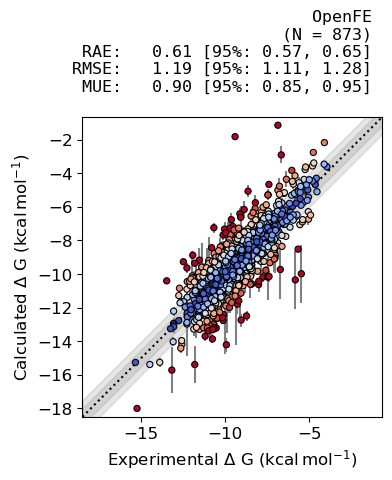

In [12]:
# OpenFE public results
f, stats_out = _master_plot(
    df_public['Exp DG (kcal/mol)'], 
    df_public['DG (kcal/mol)'], 
    'OpenFE',
    df_public['Exp dDG (kcal/mol)'], 
    df_public['uncertainty (kcal/mol)'],
    statistics=["RAE", "RMSE", "MUE"],
    filename='openfe_dg_public.png',
)

### Results centered around zero

In [13]:
df_zero_calc, df_zero_exp = _center_results_around_zero(df_public)

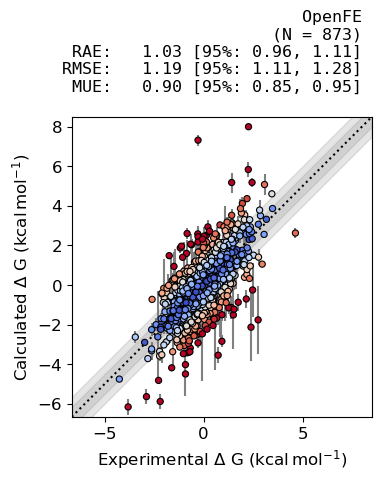

In [14]:
f, stats_out = _master_plot(
    df_zero_exp, 
    df_zero_calc, 
    'OpenFE',
    df_public['Exp dDG (kcal/mol)'], 
    df_public['uncertainty (kcal/mol)'],
    statistics=["RAE", "RMSE", "MUE"],
    filename='openfe_dg_public_zero_centered.png',
)

# Ross et al. public results

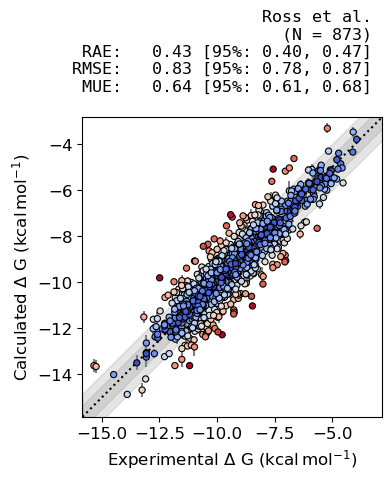

In [15]:
f, stats_out = _master_plot(
    df_fep_filtered['Exp DG (kcal/mol)'], 
    df_fep_filtered['DG (kcal/mol)'], 
    'Ross et al.',
    df_fep_filtered['Exp dDG (kcal/mol)'], 
    df_fep_filtered['uncertainty (kcal/mol)'],
    statistics=["RAE", "RMSE", "MUE"],
    filename='fep+_dg_public.png',
)

### Results centered around zero

In [16]:
# Center results around zero
df_zero_calc_fep, df_zero_exp_fep = _center_results_around_zero(df_fep_filtered)

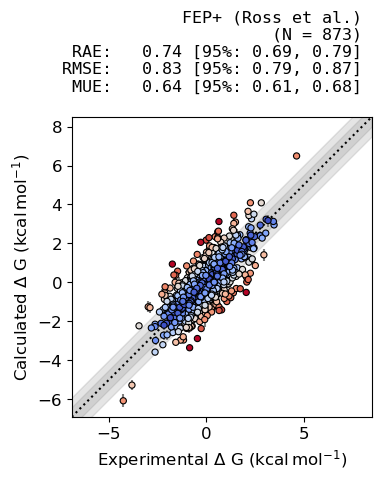

In [17]:
f, stats_out = _master_plot(
    df_zero_exp_fep, 
    df_zero_calc_fep, 
    'FEP+ (Ross et al.)',
    df_fep_filtered['Exp dDG (kcal/mol)'], 
    df_fep_filtered['uncertainty (kcal/mol)'],
    statistics=["RAE", "RMSE", "MUE"],
    xy_lim = [-6.9, 8.5],
    filename='fep+_dg_zerocentered.png',
)

## OpenFE private sets

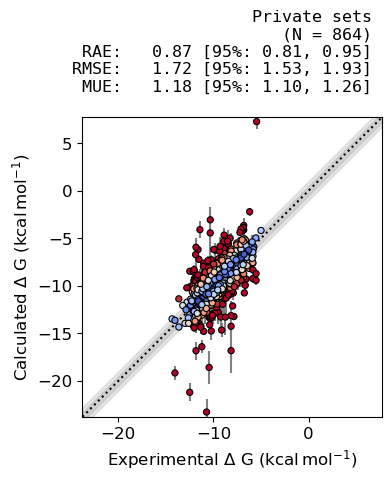

In [18]:
f, stats_out = _master_plot(
    df_private['Exp DG (kcal/mol)'], 
    df_private['DG (kcal/mol)'], 
    'Private sets',
    df_private['Exp dDG (kcal/mol)'], 
    df_private['uncertainty (kcal/mol)'],
    statistics=["RAE", "RMSE", "MUE"],
    filename='openfe_dg_private.png',
)

### Results centered around zero

In [19]:
# Center results around zero
df_zero_calc_private, df_zero_exp_private = _center_results_around_zero(df_private)

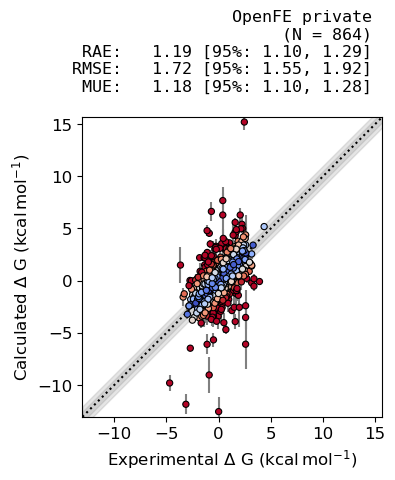

In [20]:
f, stats_out = _master_plot(
    df_zero_exp_private, 
    df_zero_calc_private, 
    'OpenFE private',
    df_private['Exp dDG (kcal/mol)'], 
    df_private['uncertainty (kcal/mol)'],
    statistics=["RAE", "RMSE", "MUE"],
    filename='openfe_dg_private_zero_centered.png',
)

## Plot the DG calc. vs. exp. of all systems separately

/Users/hannahbaumann/miniforge3/envs/openfe_dev/lib/python3.12/site-packages/cinnabar/stats.py:92: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return scipy.stats.pearsonr(y_true_sample, y_pred_sample)[0]
/Users/hannahbaumann/miniforge3/envs/openfe_dev/lib/python3.12/site-packages/cinnabar/stats.py:92: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return scipy.stats.pearsonr(y_true_sample, y_pred_sample)[0]
/var/folders/56/3yvgkyg96rvchgjgzfbf16gc0000gn/T/ipykernel_4395/2463770817.py:105: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(figsize, figsize))


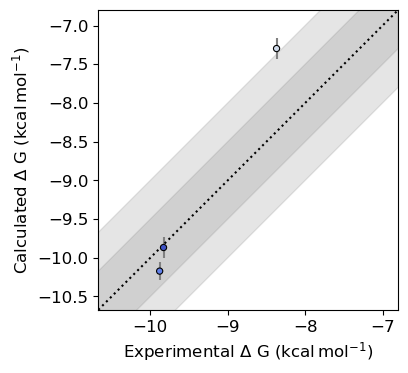

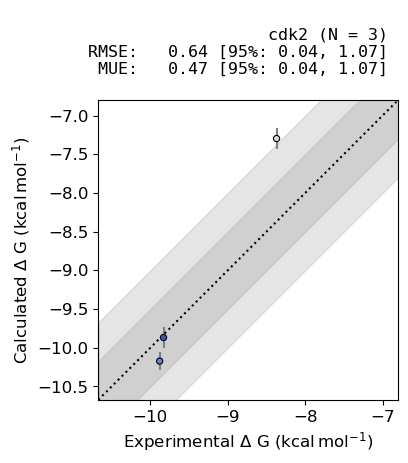

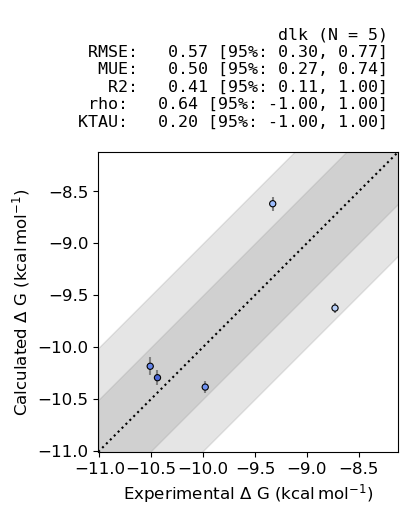

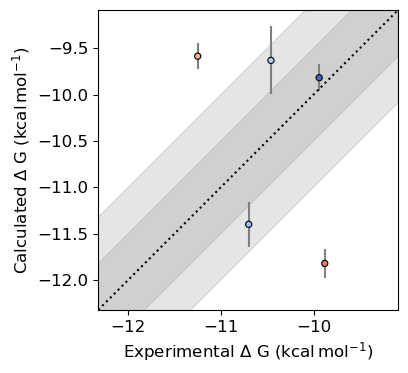

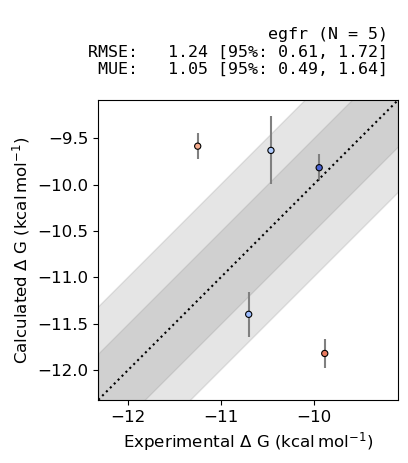

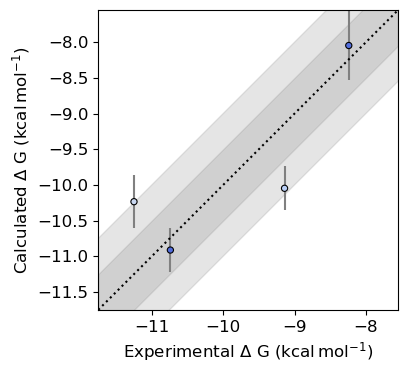

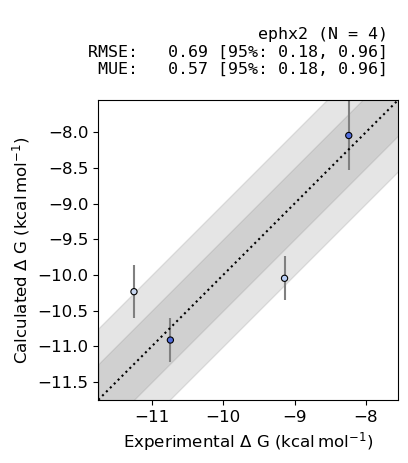

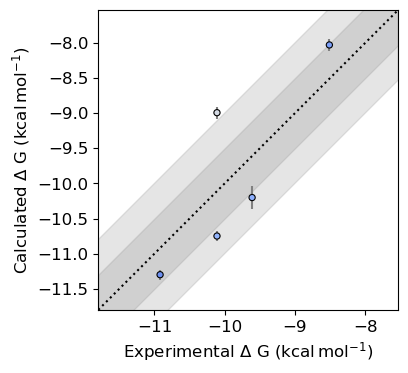

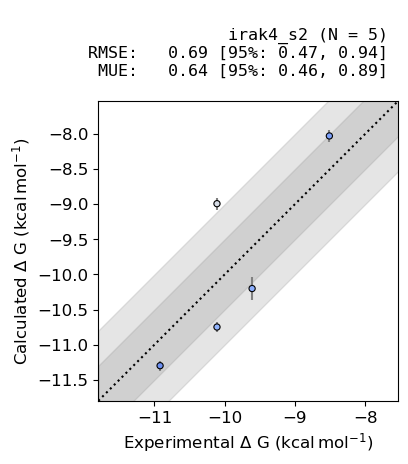

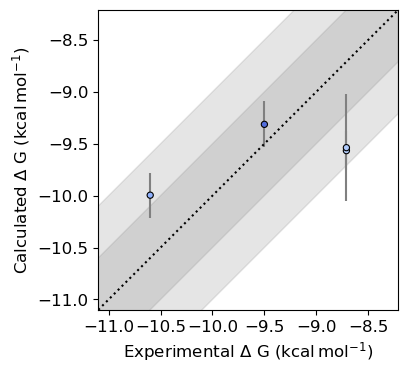

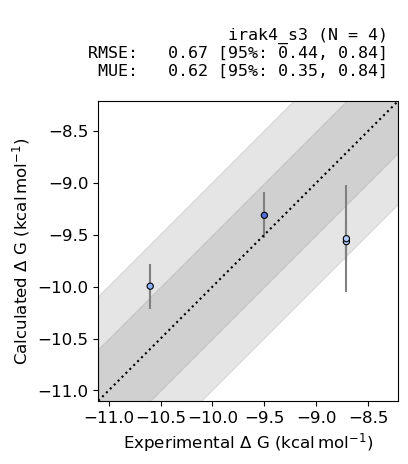

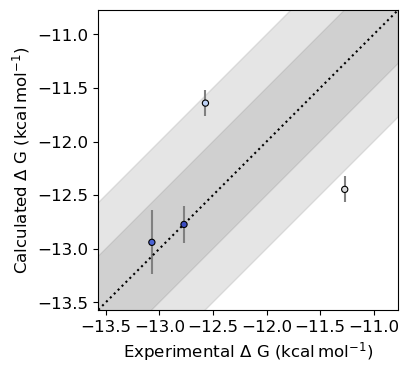

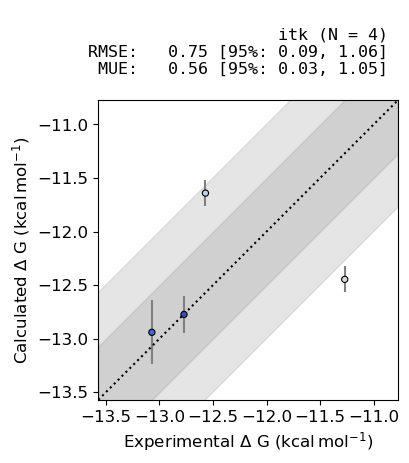

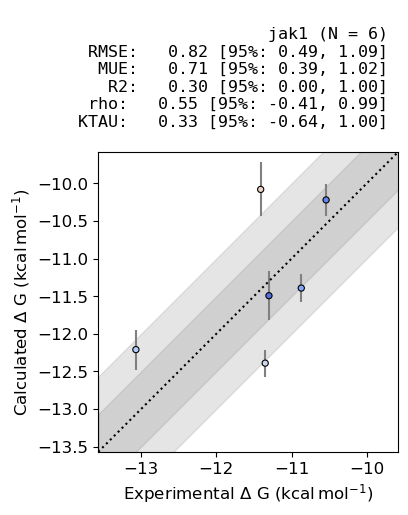

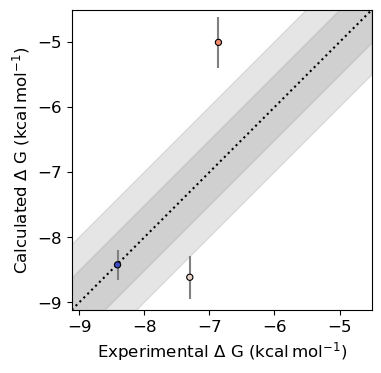

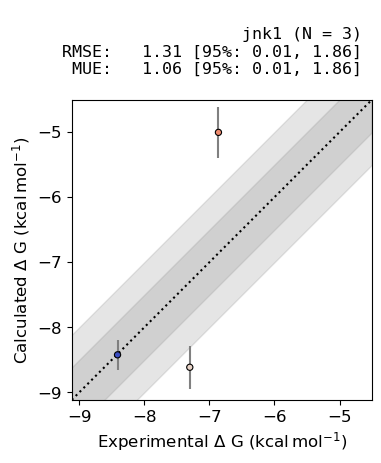

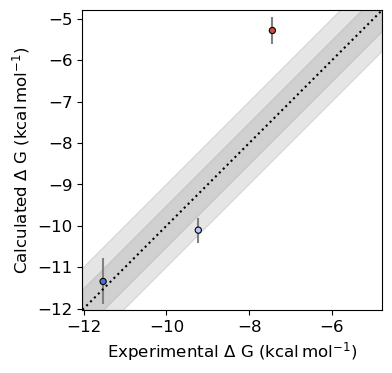

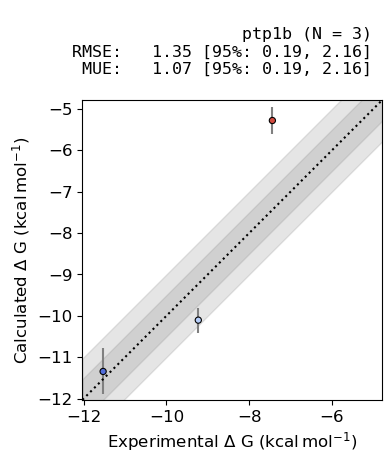

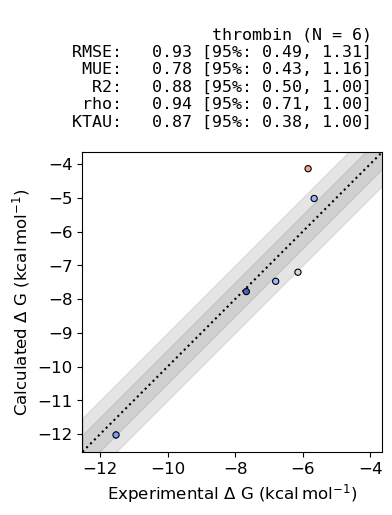

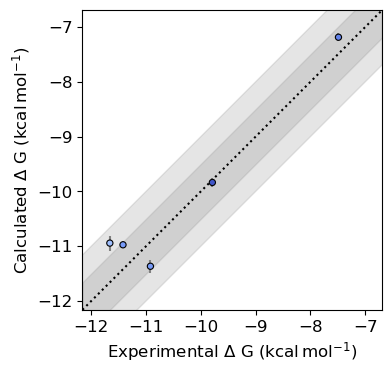

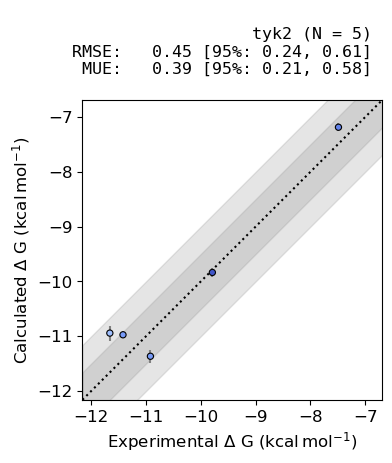

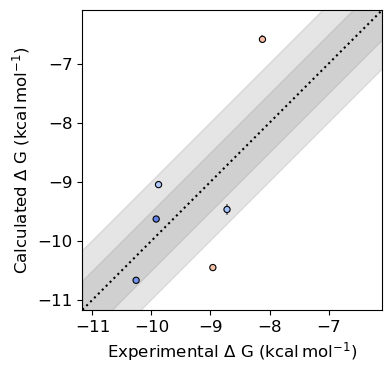

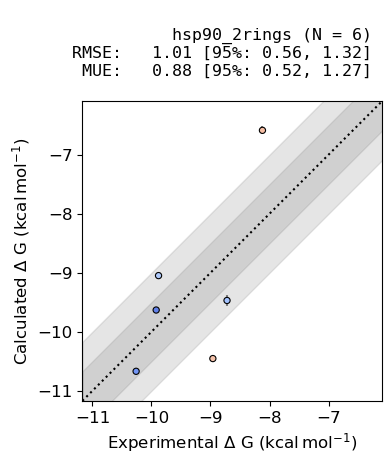

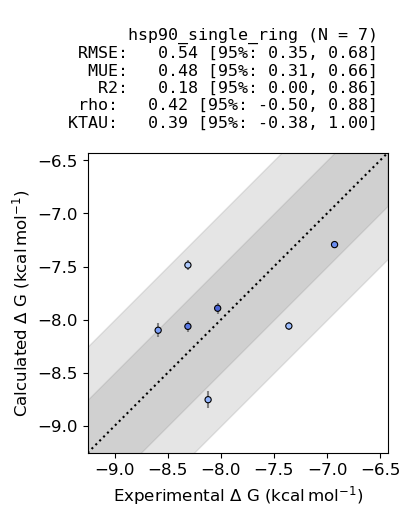

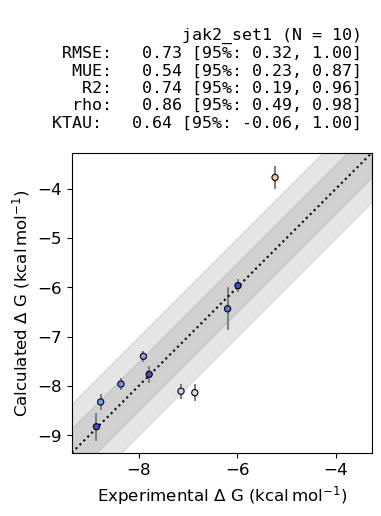

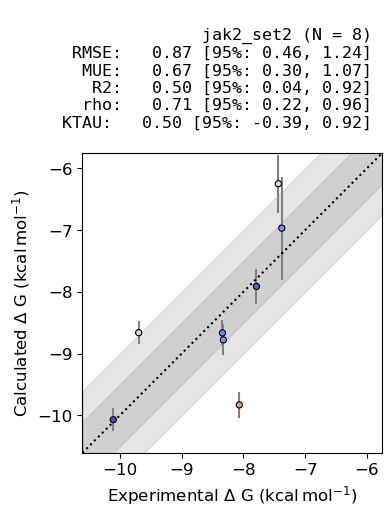

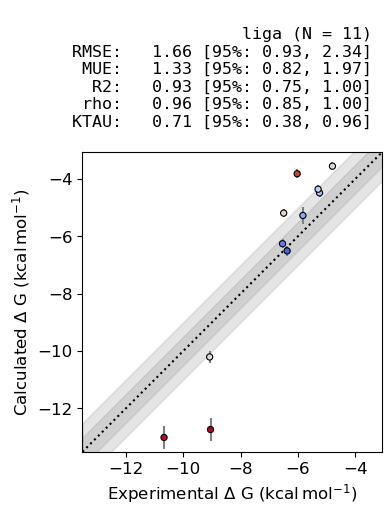

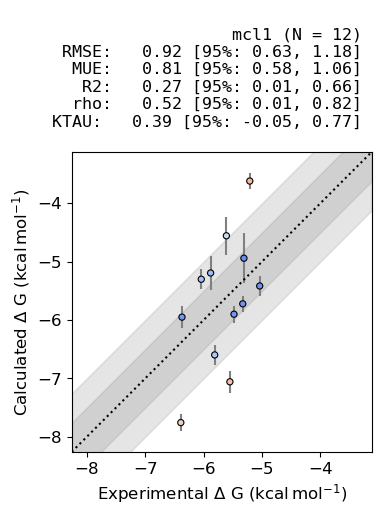

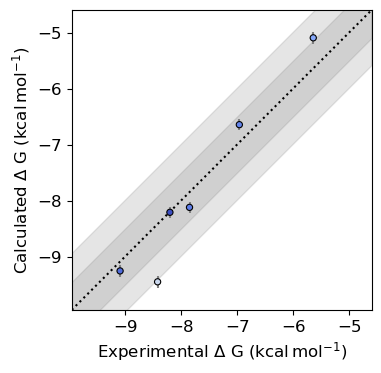

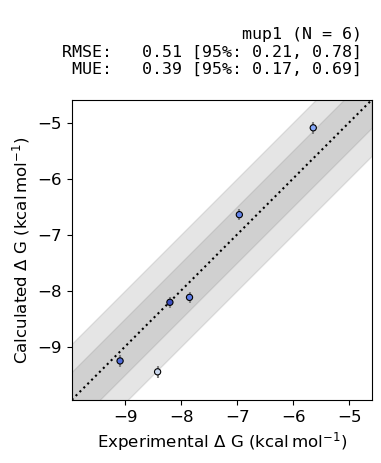

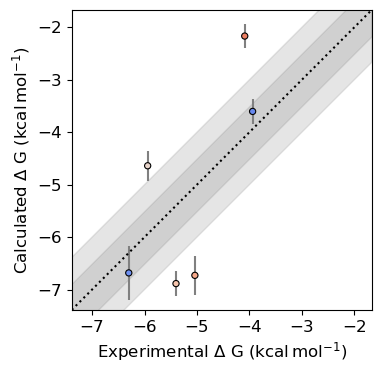

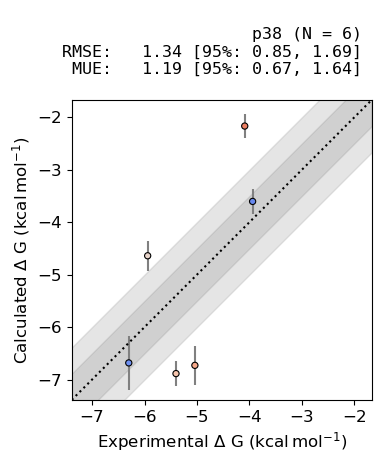

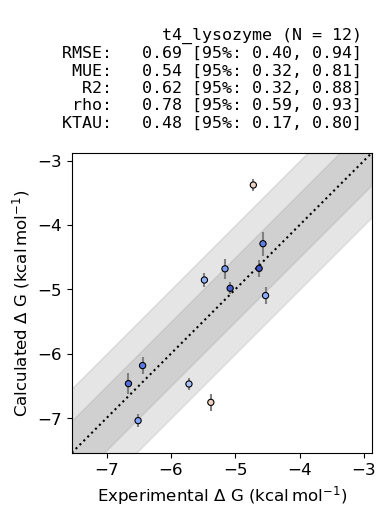

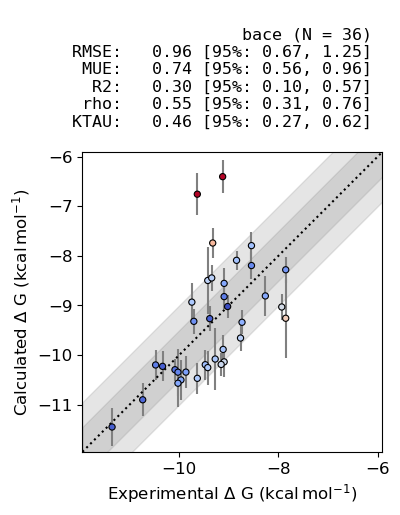

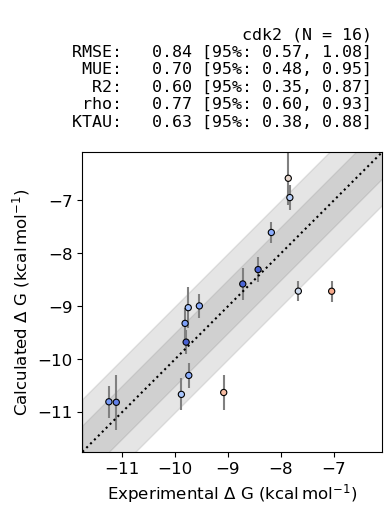

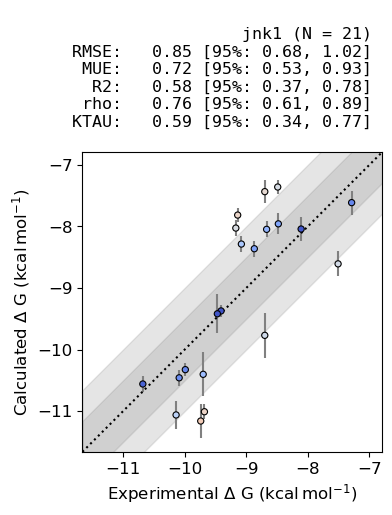

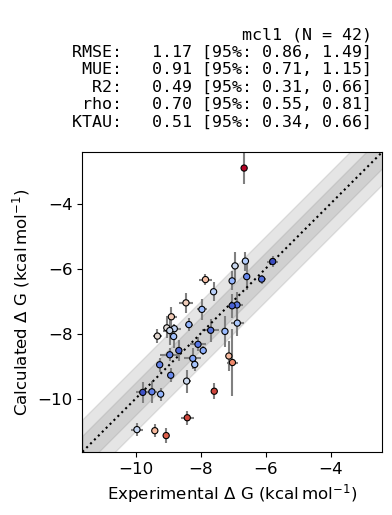

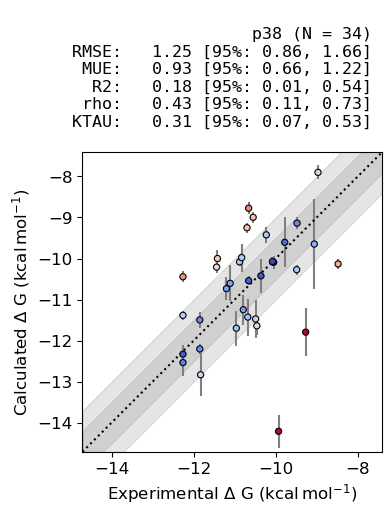

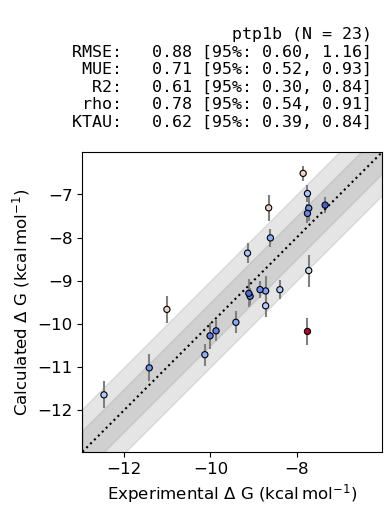

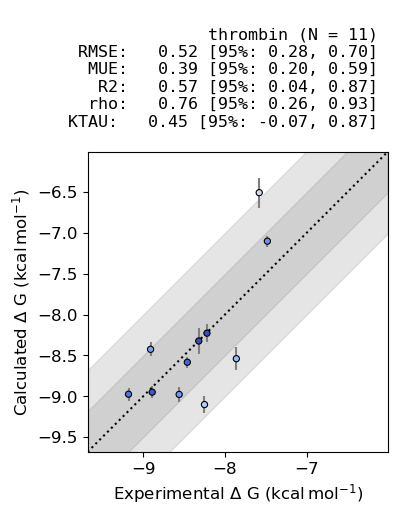

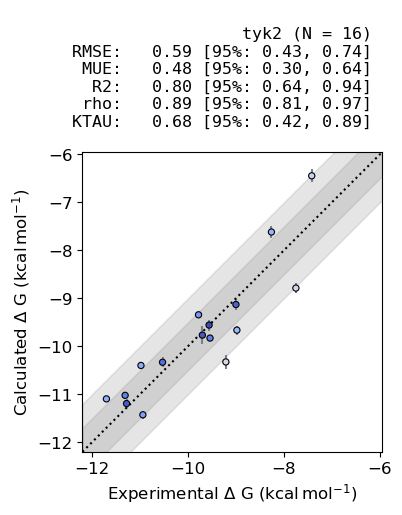

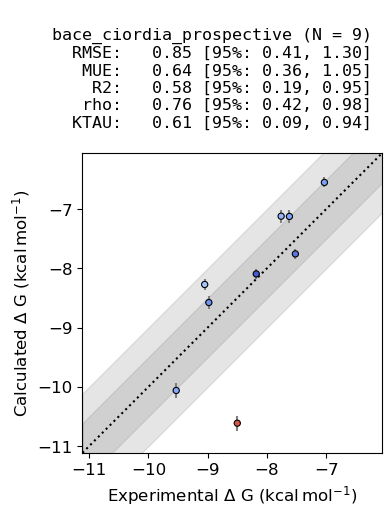

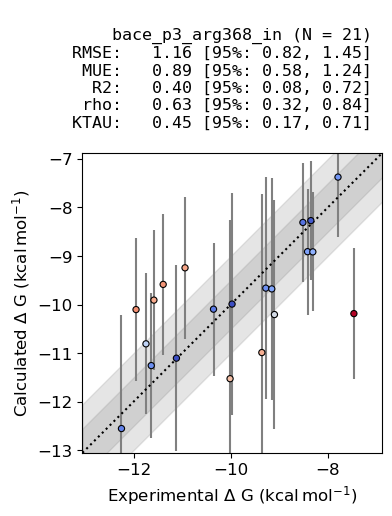

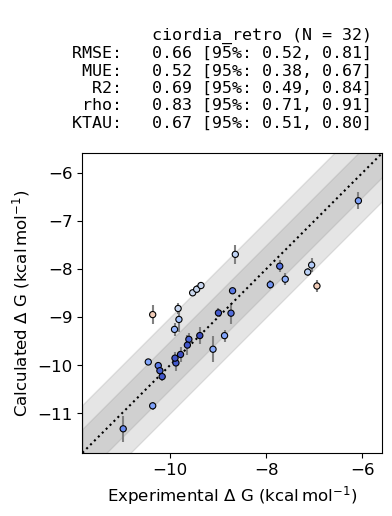

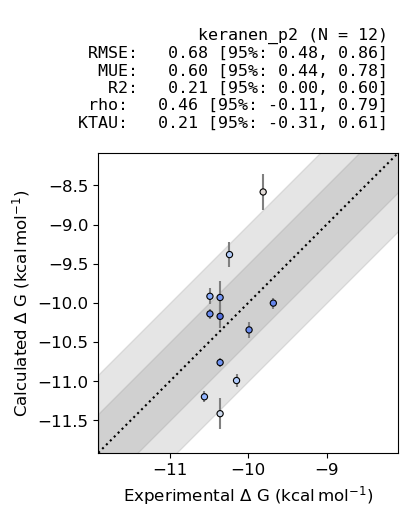

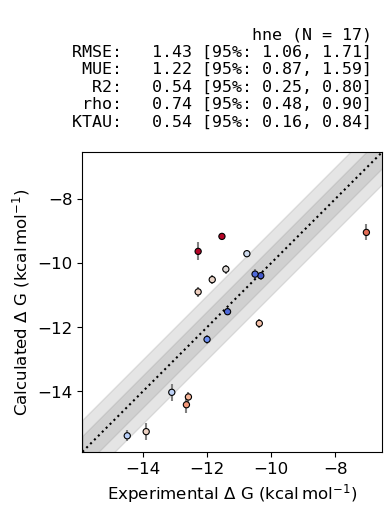

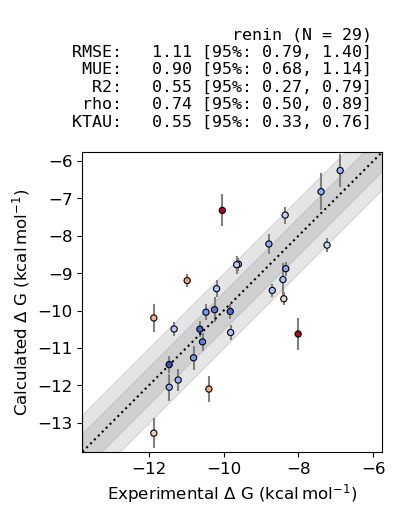

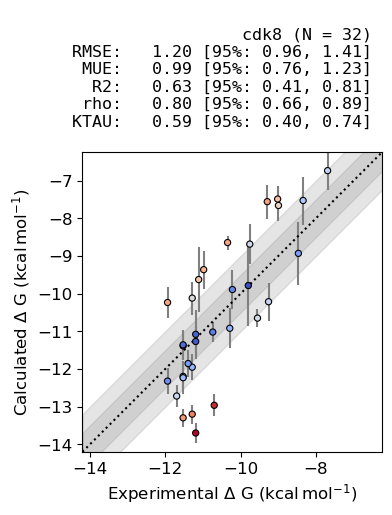

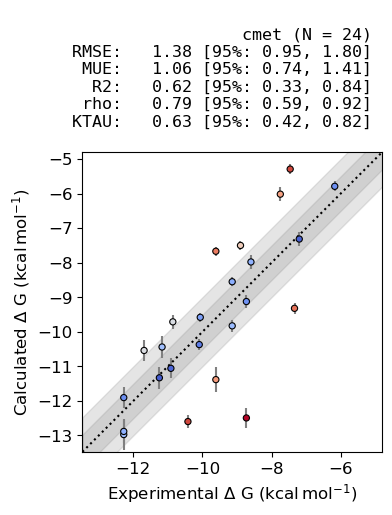

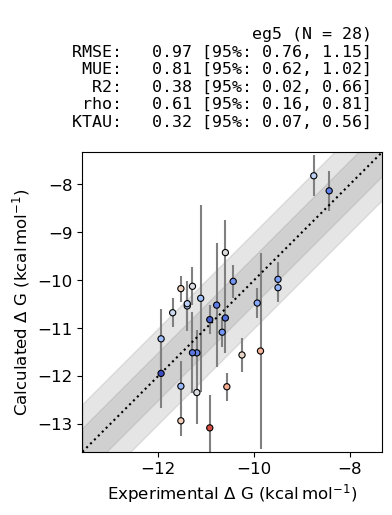

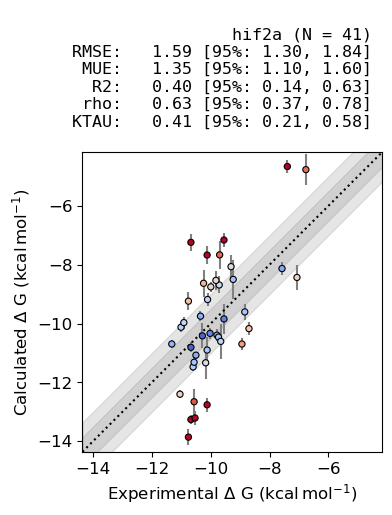

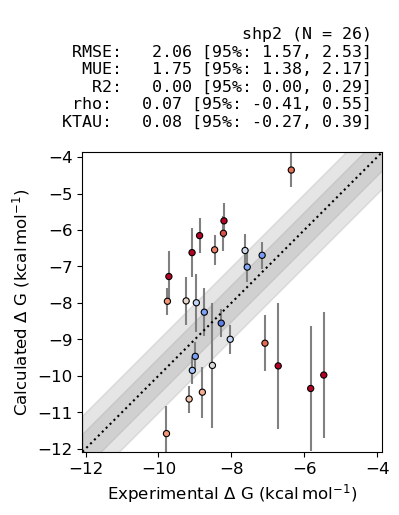

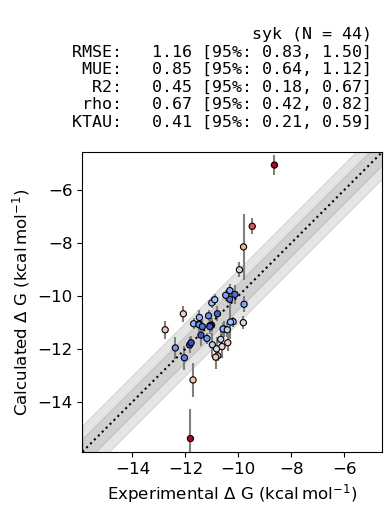

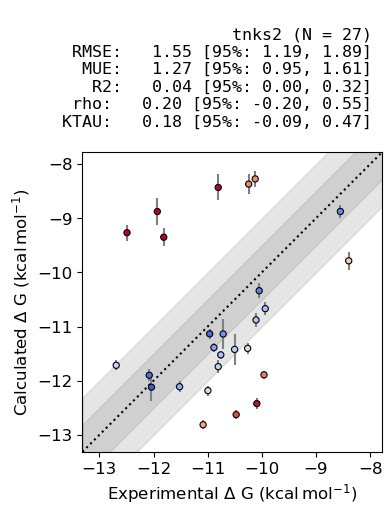

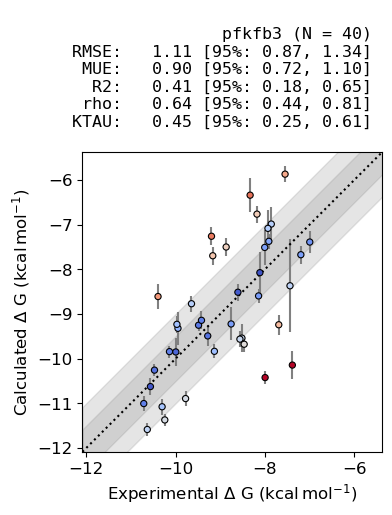

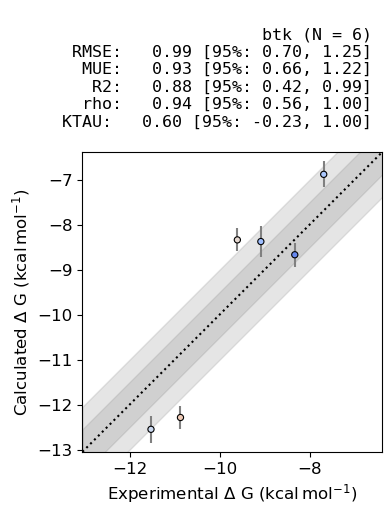

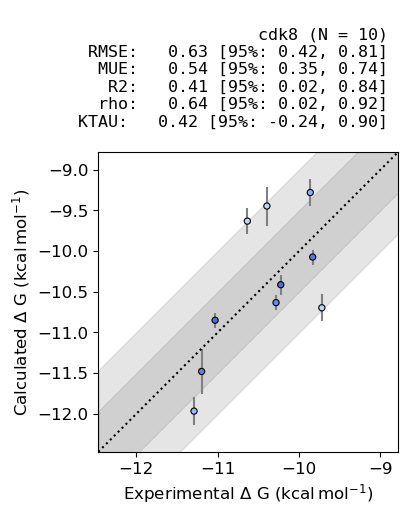

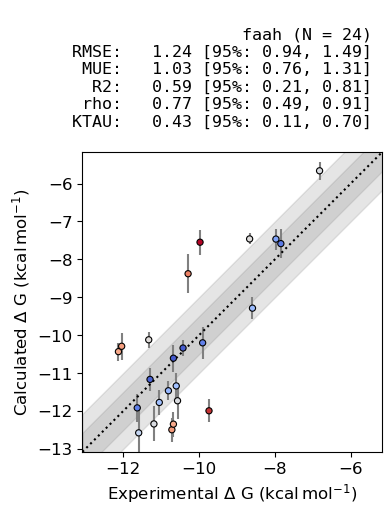

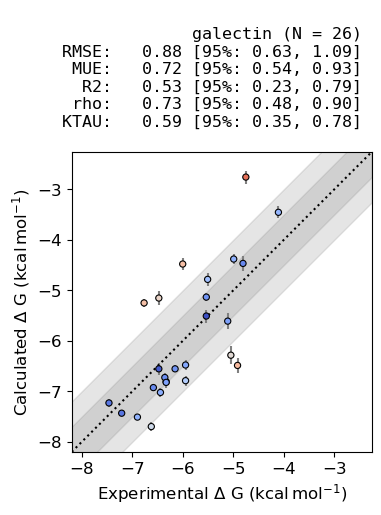

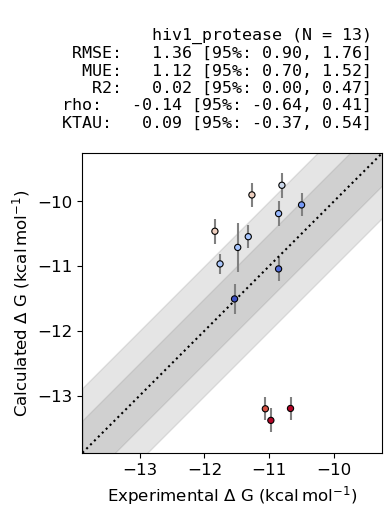

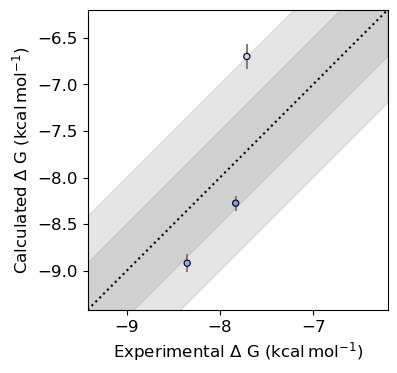

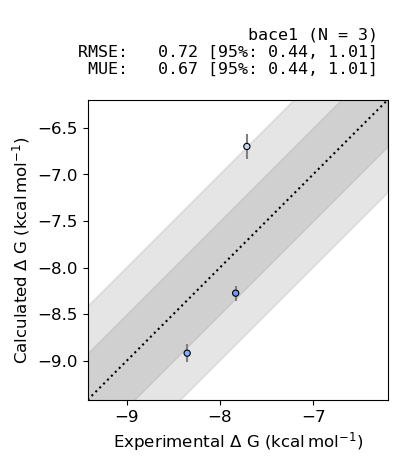

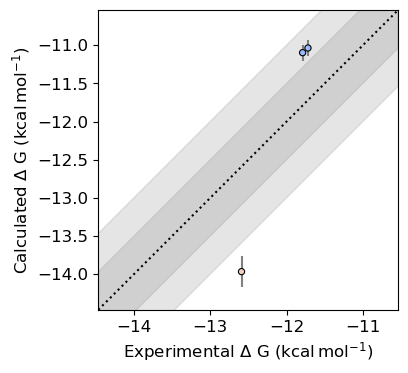

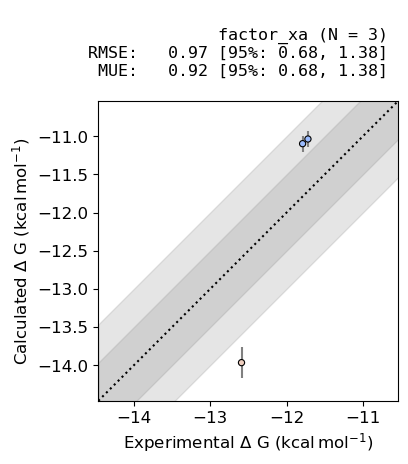

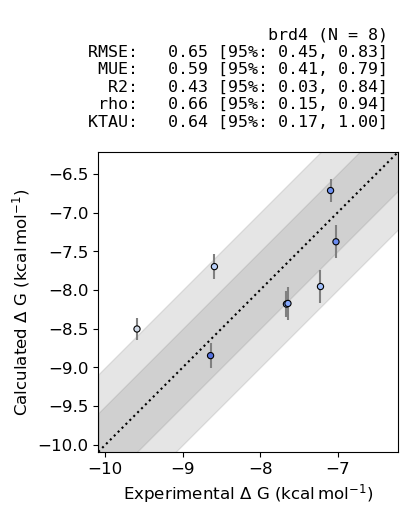

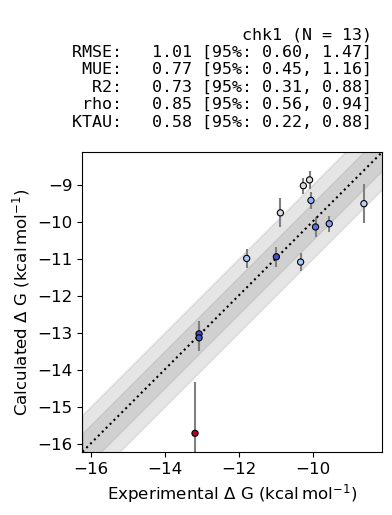

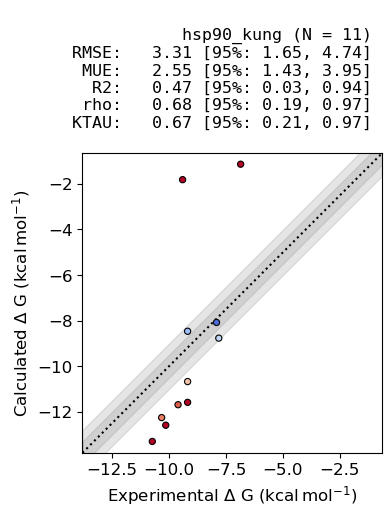

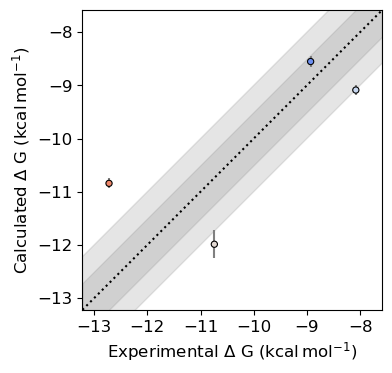

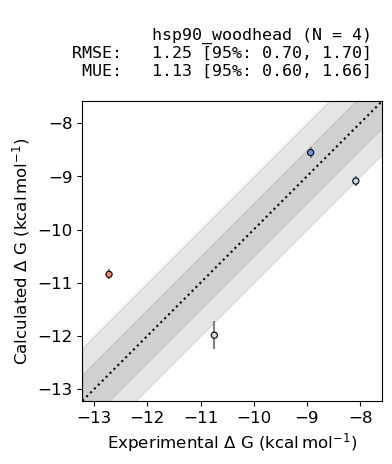

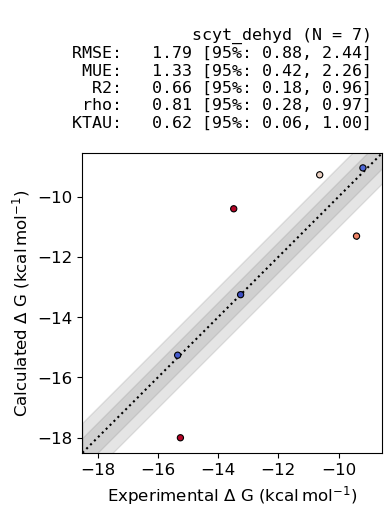

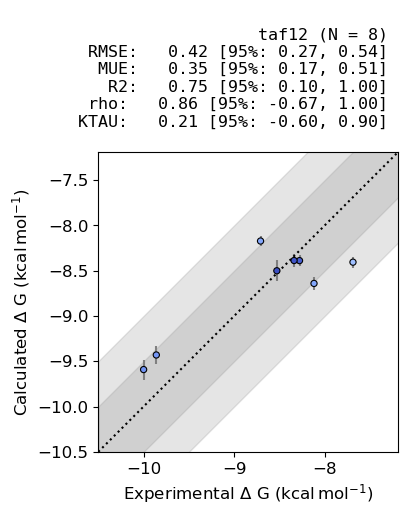

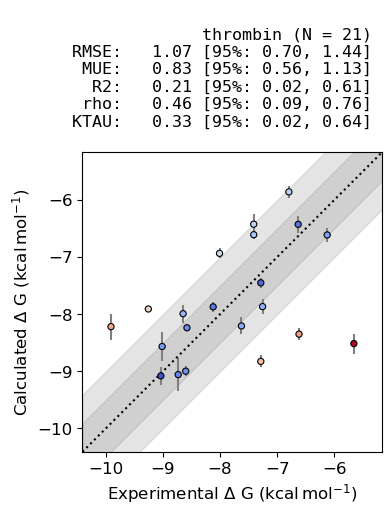

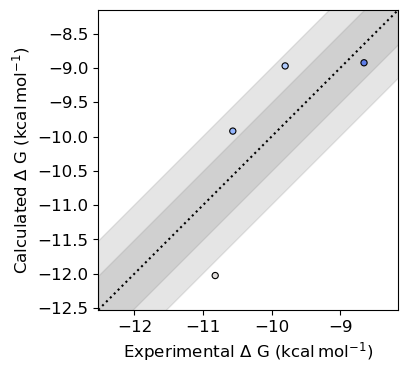

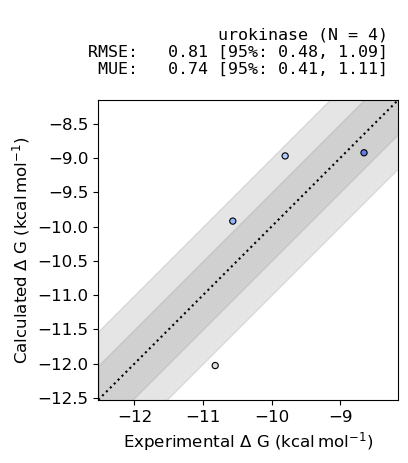

In [21]:
# OpenFE public
dg_plot_per_system(df_public, 'openfe_public')

/var/folders/56/3yvgkyg96rvchgjgzfbf16gc0000gn/T/ipykernel_4395/2463770817.py:105: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(figsize, figsize))
/Users/hannahbaumann/miniforge3/envs/openfe_dev/lib/python3.12/site-packages/cinnabar/stats.py:92: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return scipy.stats.pearsonr(y_true_sample, y_pred_sample)[0]
/Users/hannahbaumann/miniforge3/envs/openfe_dev/lib/python3.12/site-packages/cinnabar/stats.py:92: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return scipy.stats.pearsonr(y_true_sample, y_pred_sample)[0]


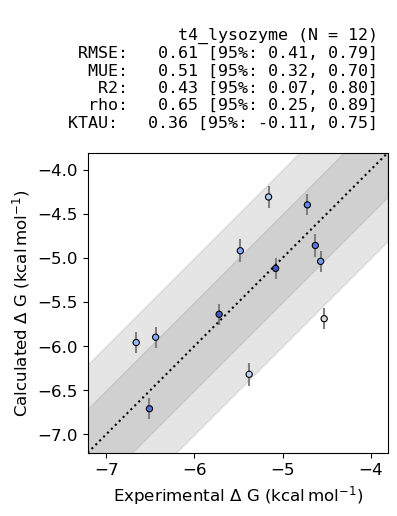

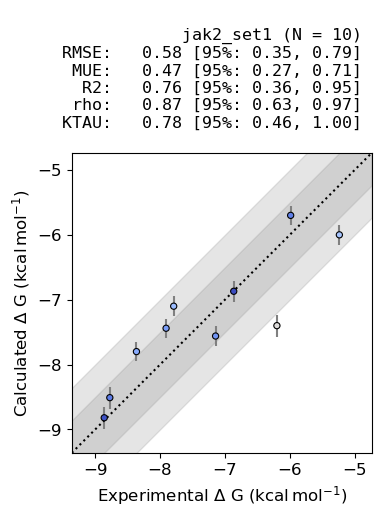

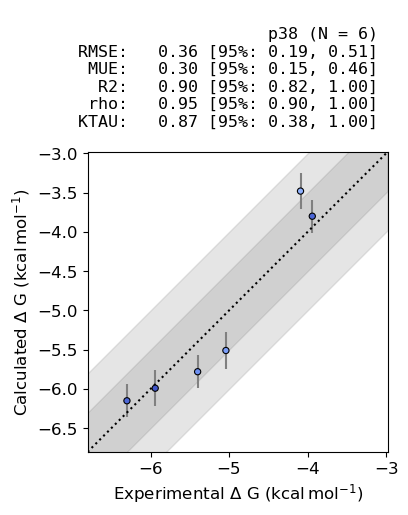

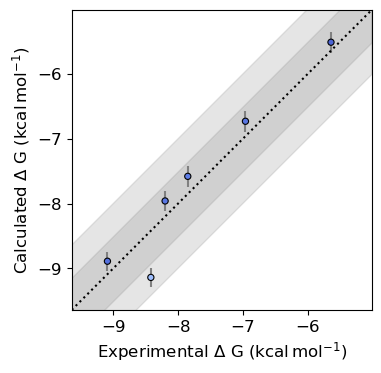

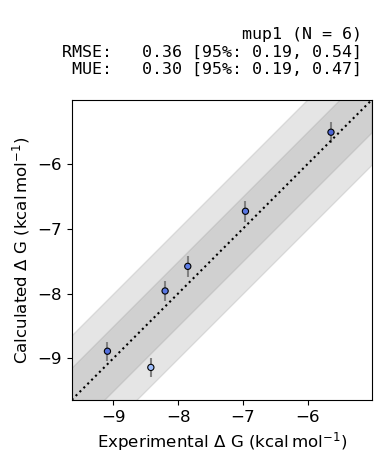

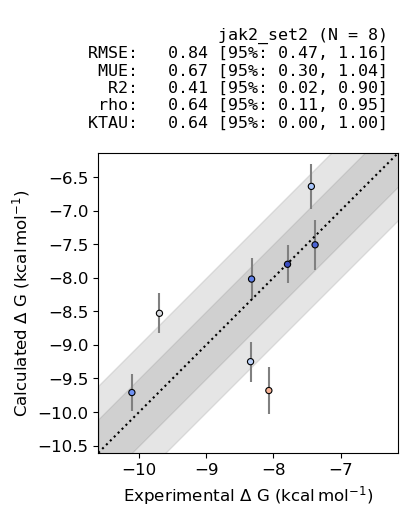

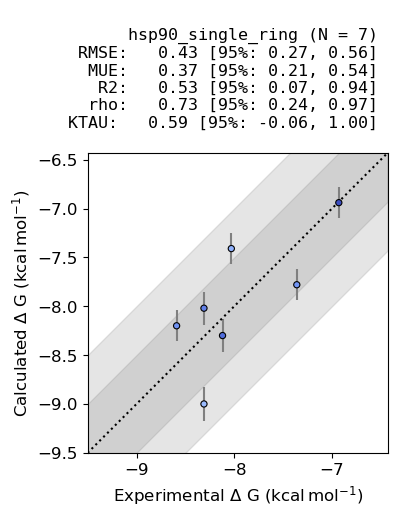

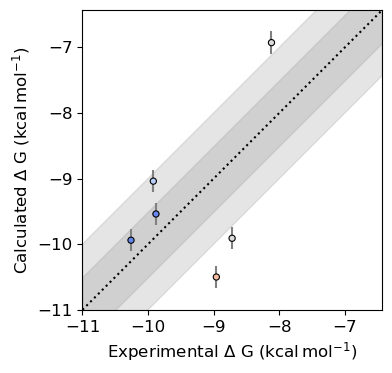

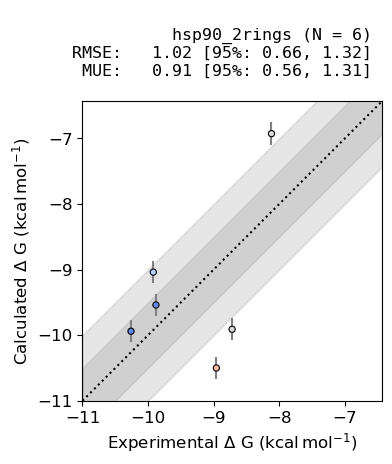

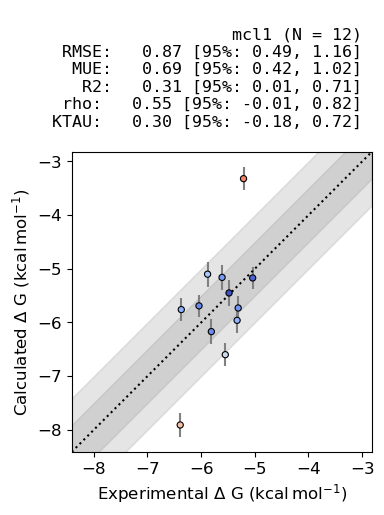

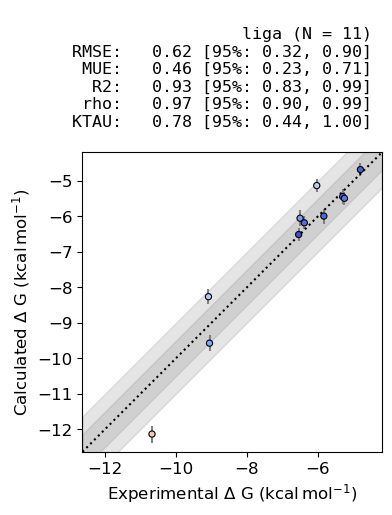

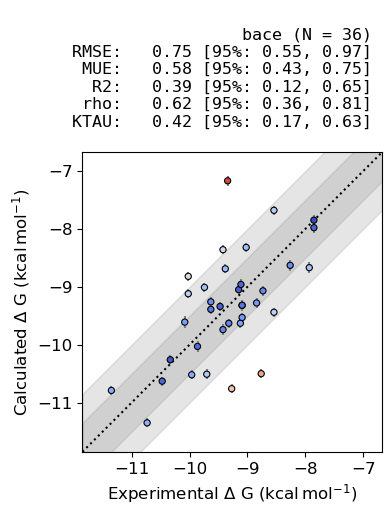

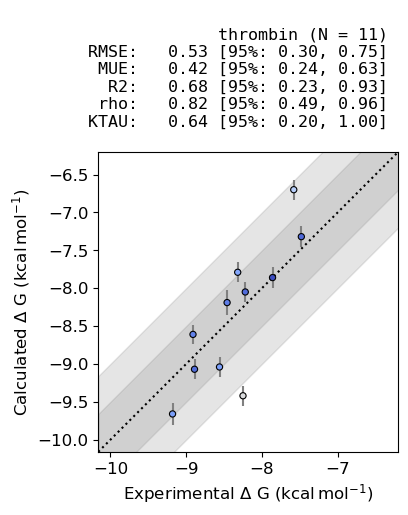

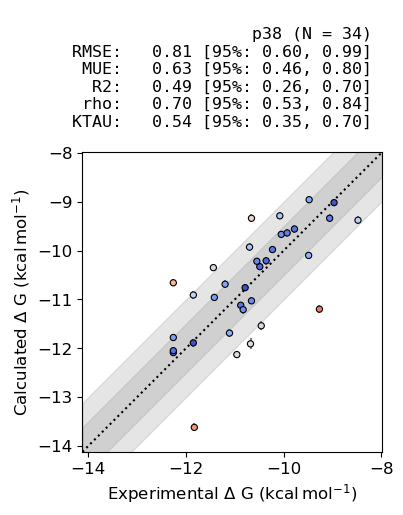

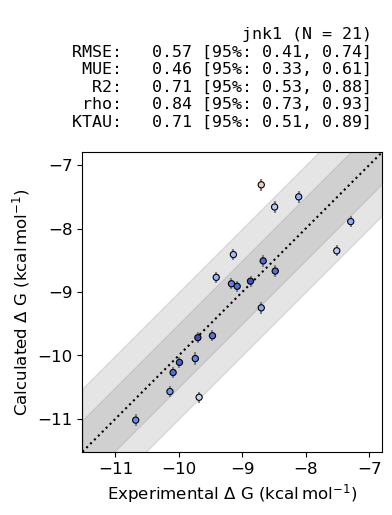

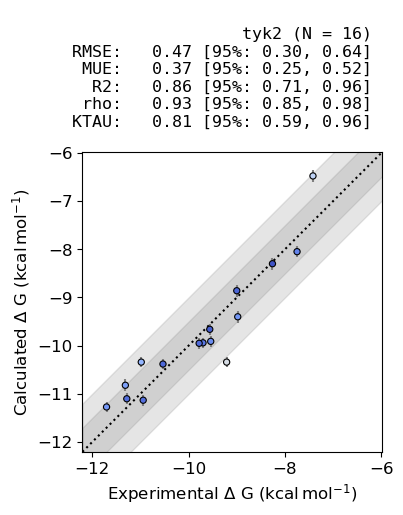

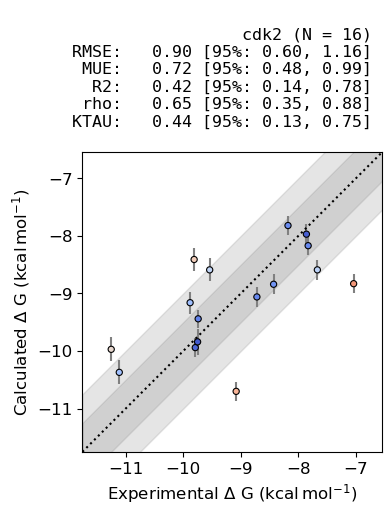

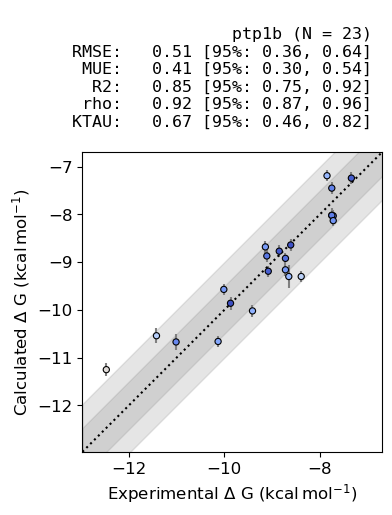

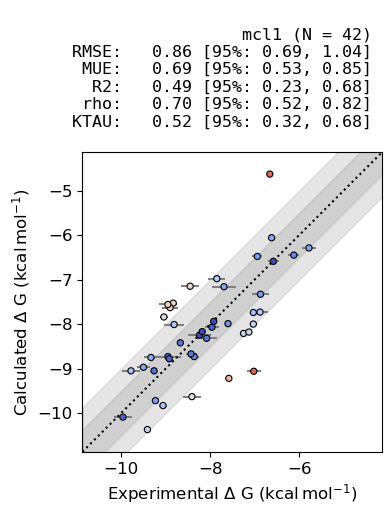

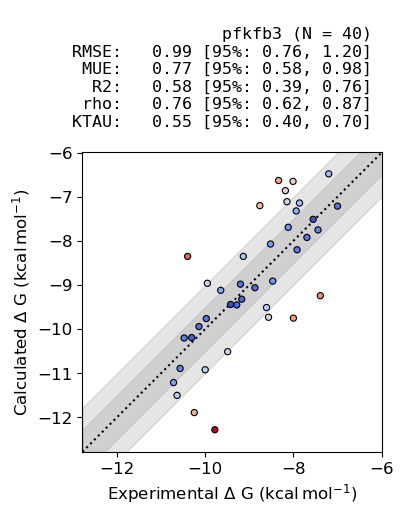

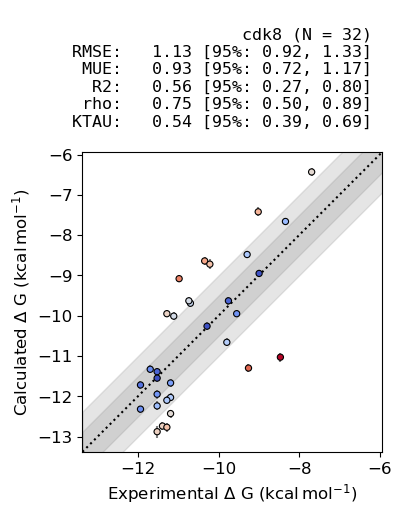

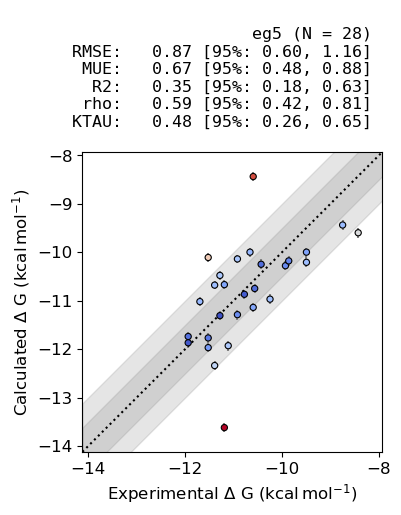

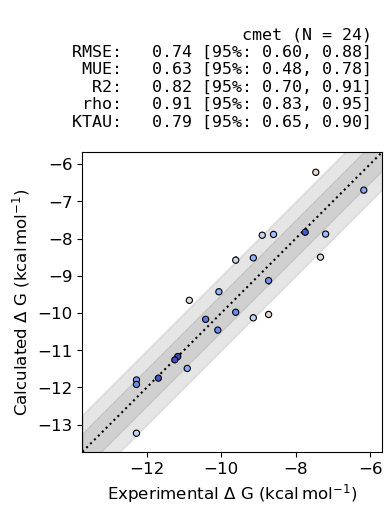

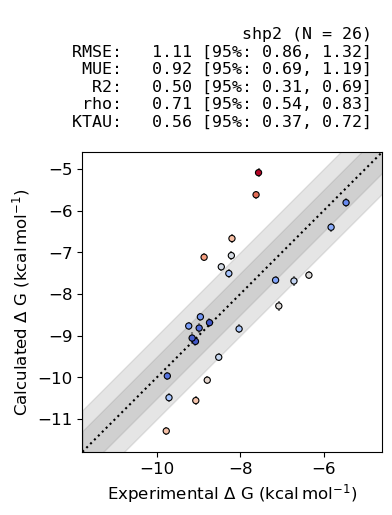

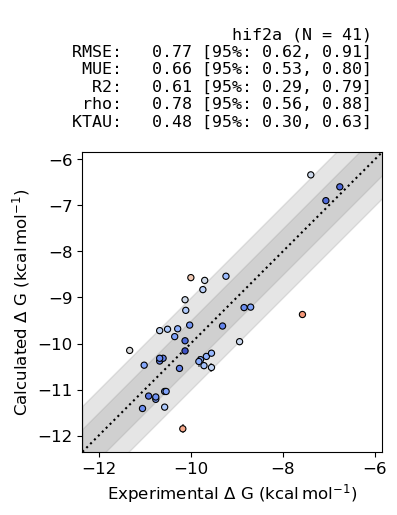

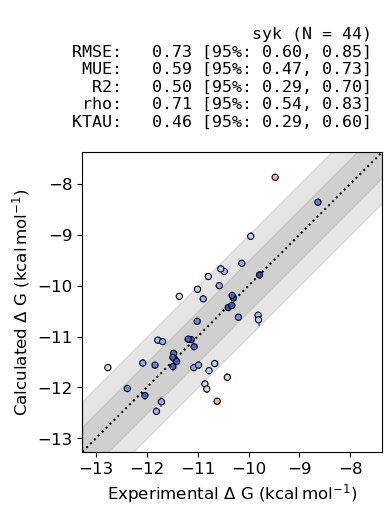

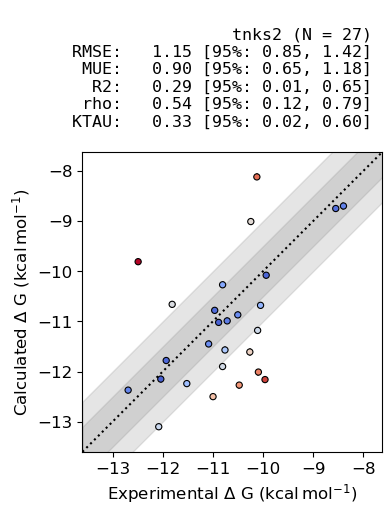

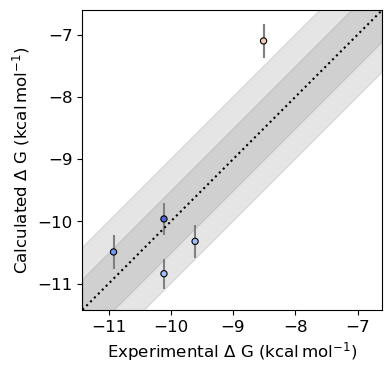

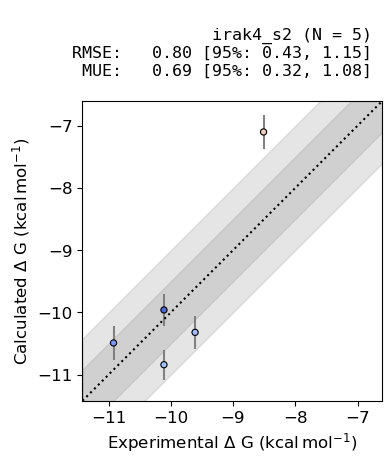

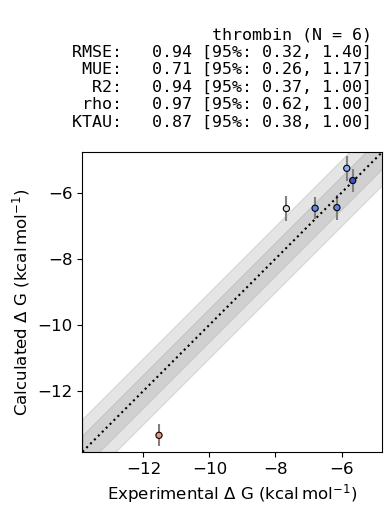

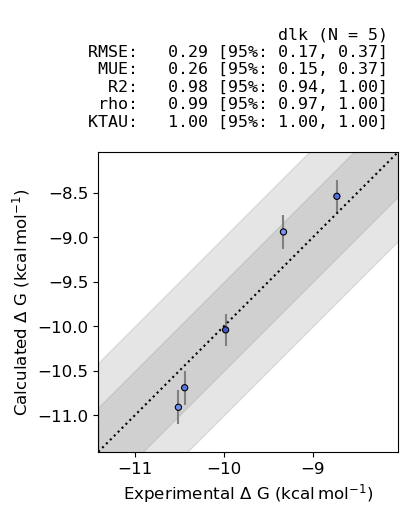

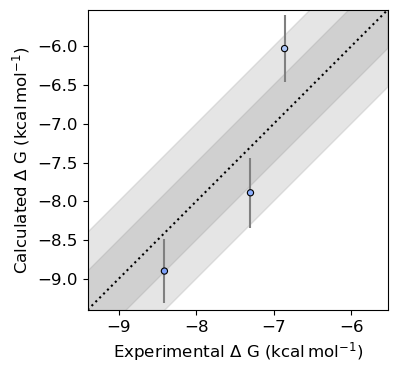

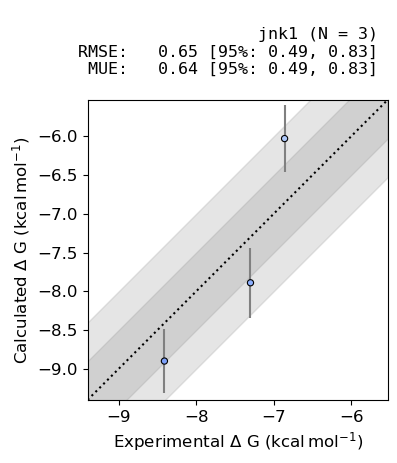

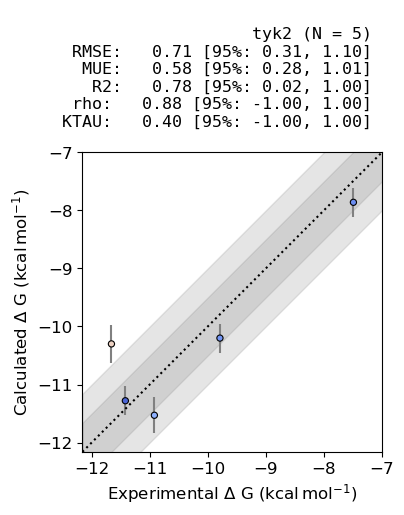

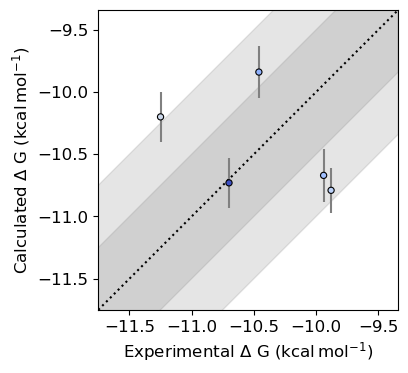

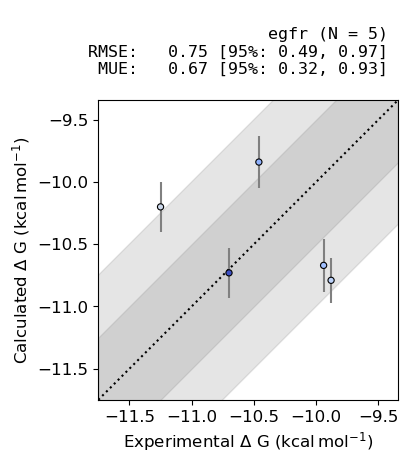

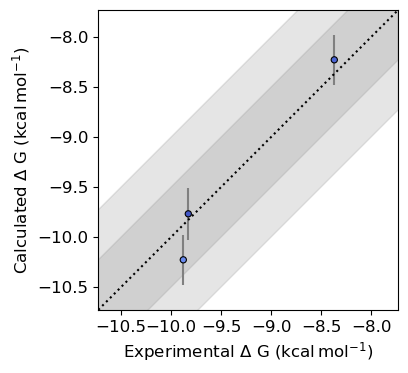

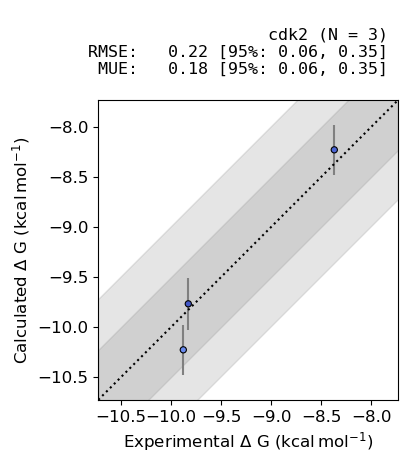

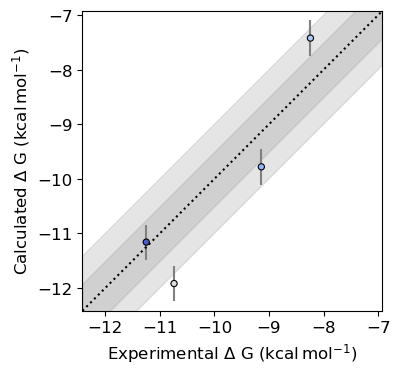

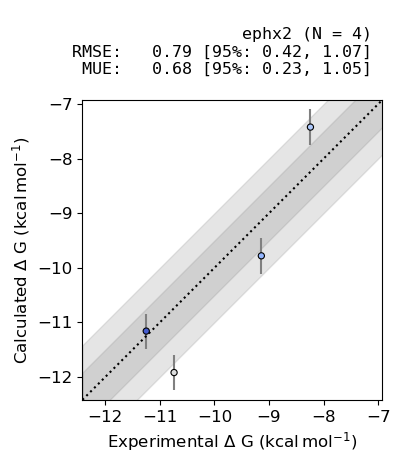

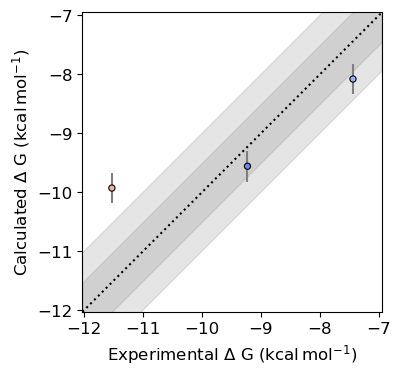

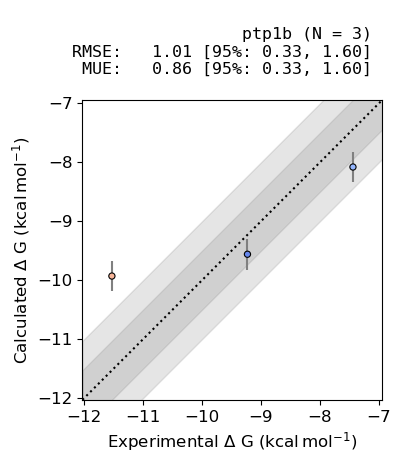

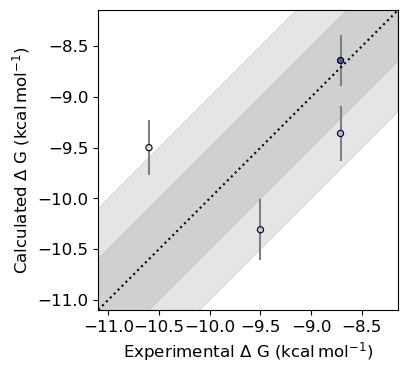

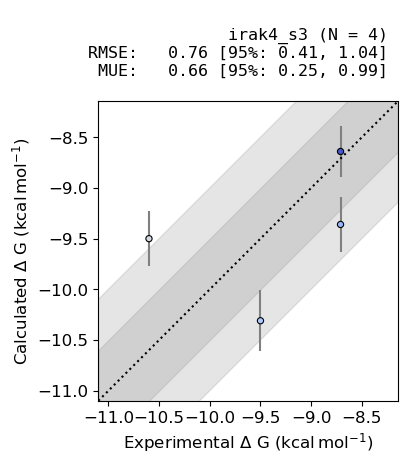

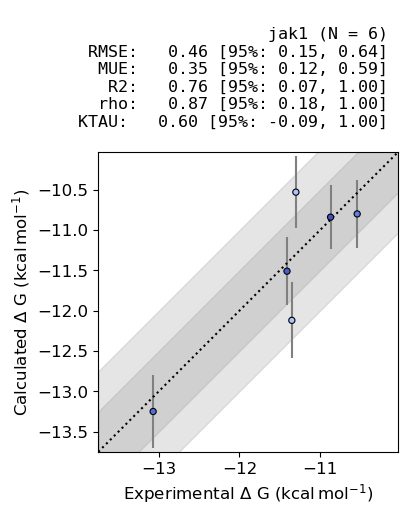

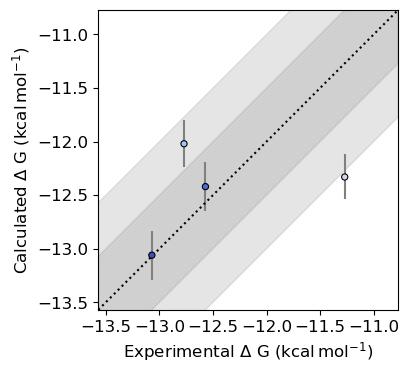

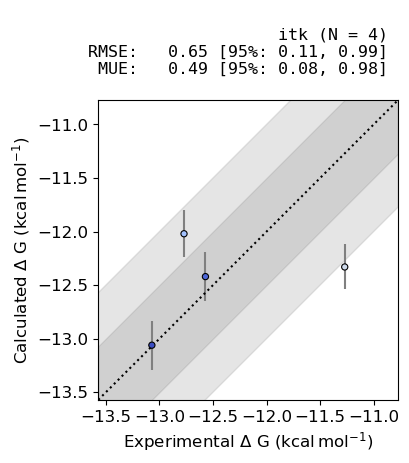

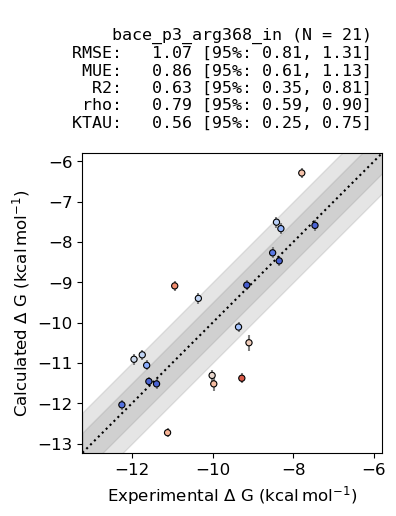

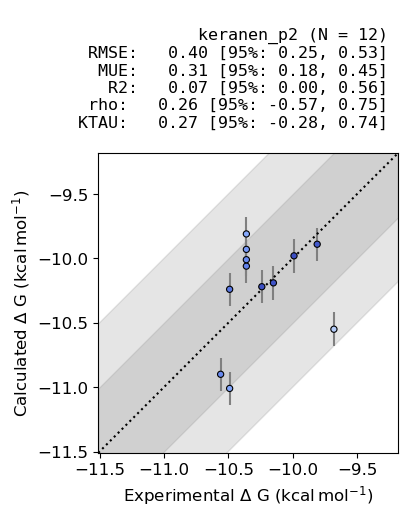

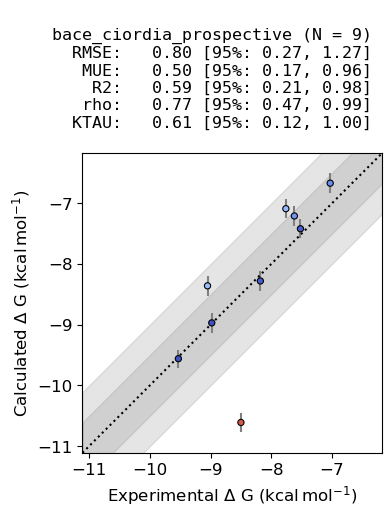

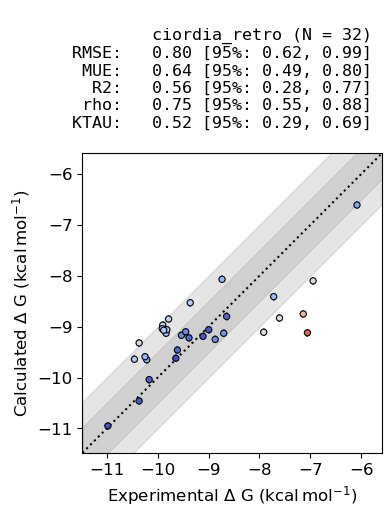

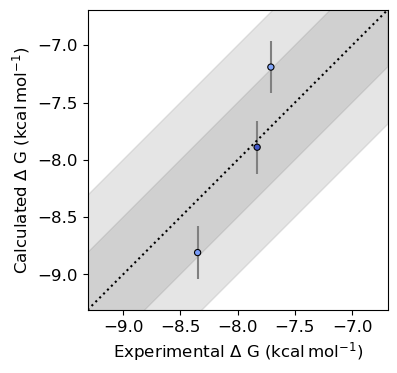

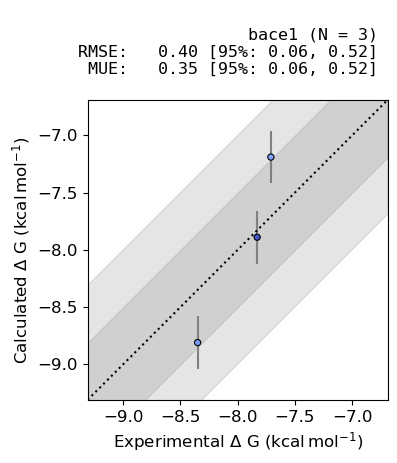

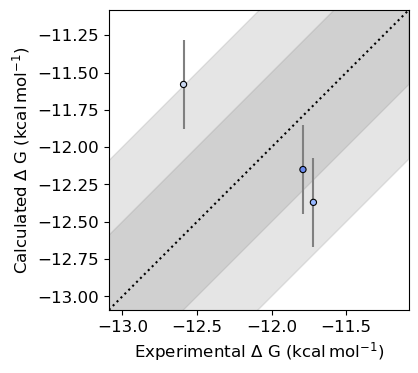

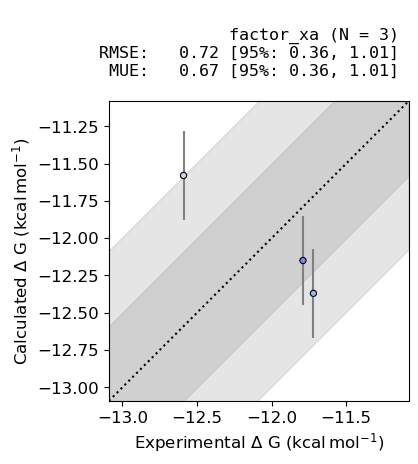

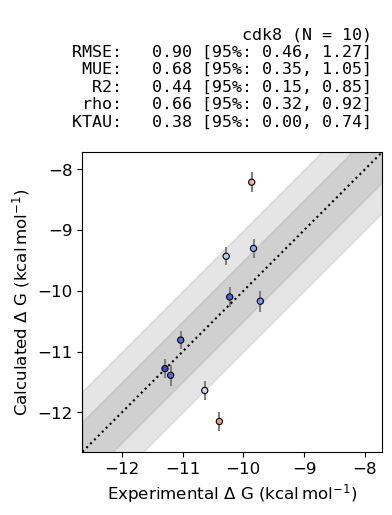

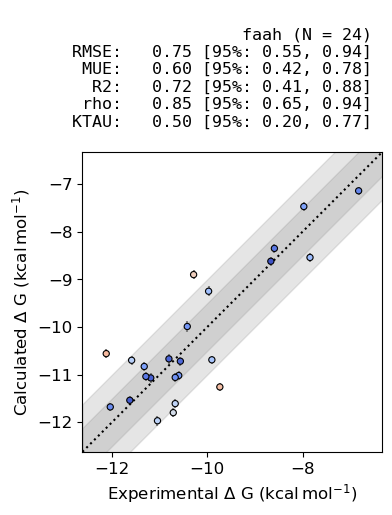

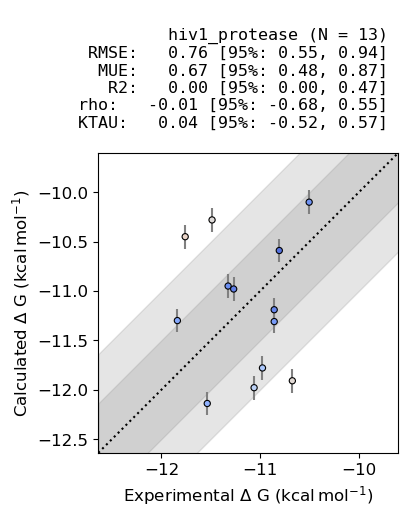

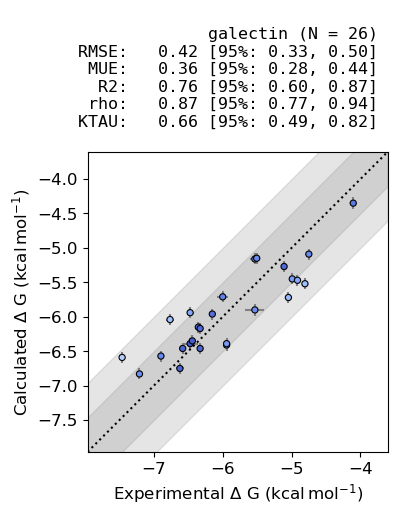

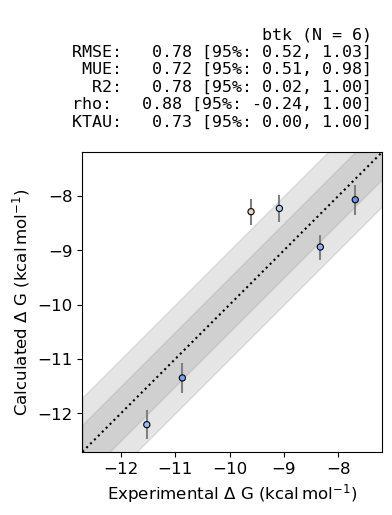

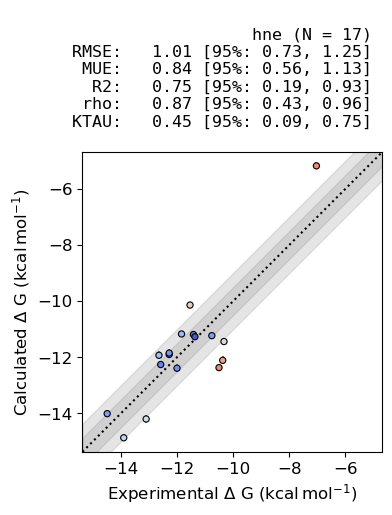

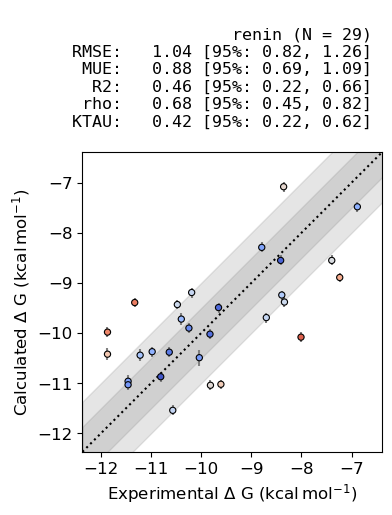

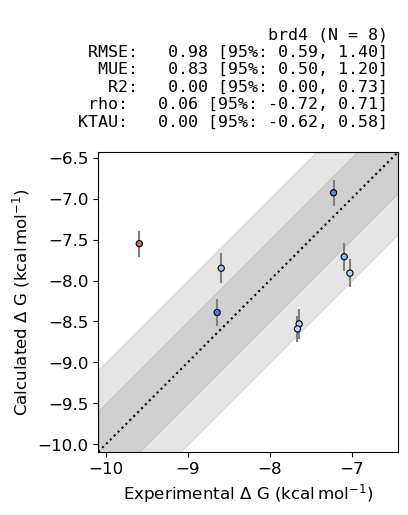

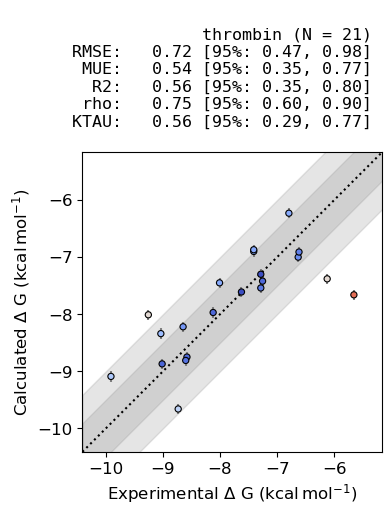

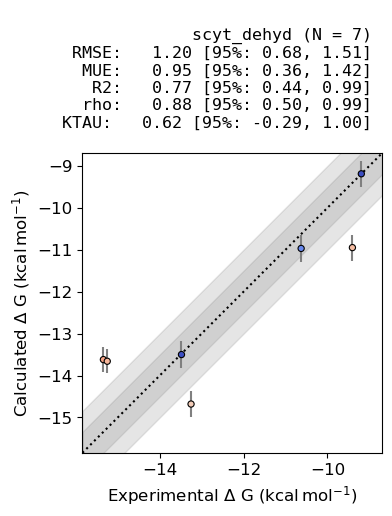

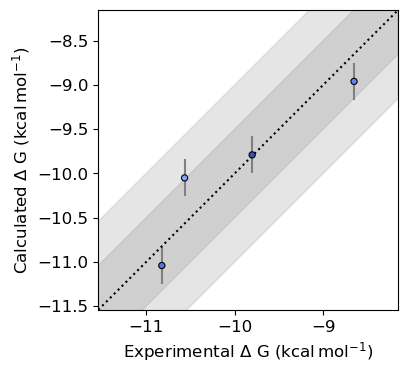

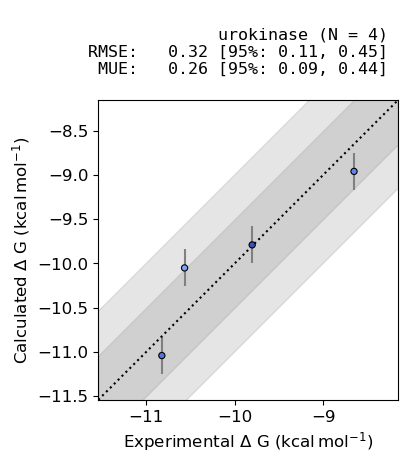

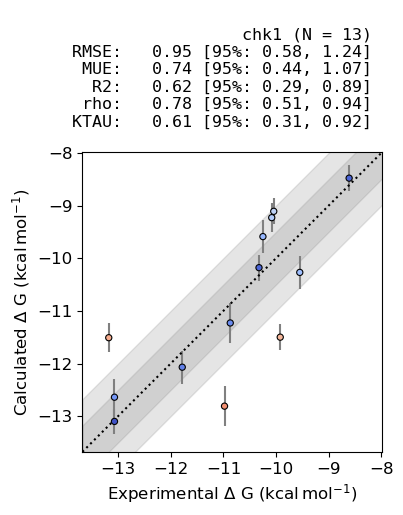

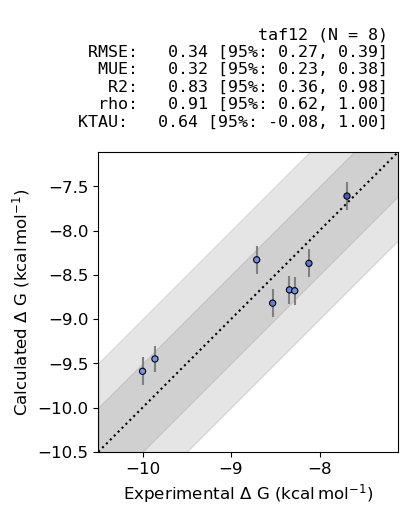

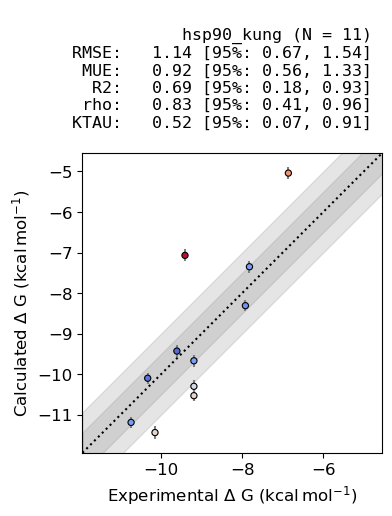

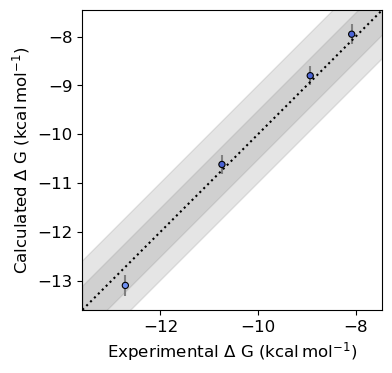

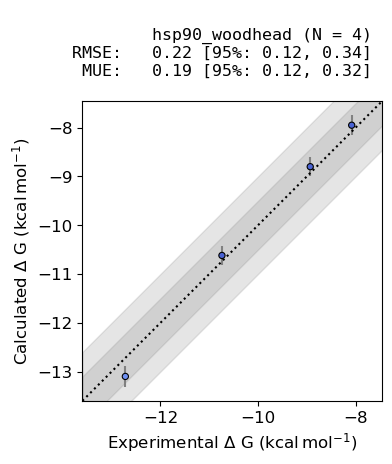

In [22]:
# Ross et al. public
dg_plot_per_system(df_fep_filtered, 'fep+_public')

/var/folders/56/3yvgkyg96rvchgjgzfbf16gc0000gn/T/ipykernel_4395/2463770817.py:105: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(figsize, figsize))


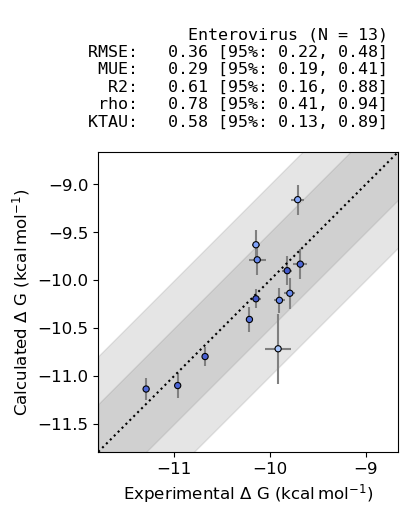

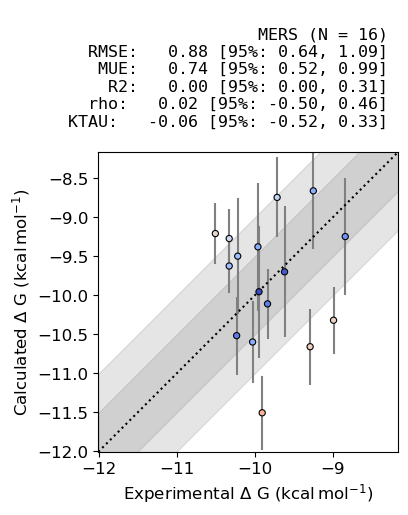

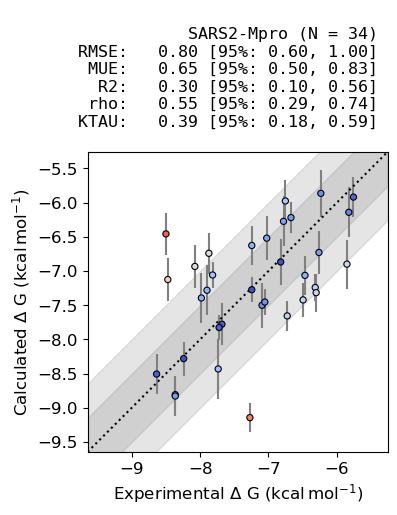

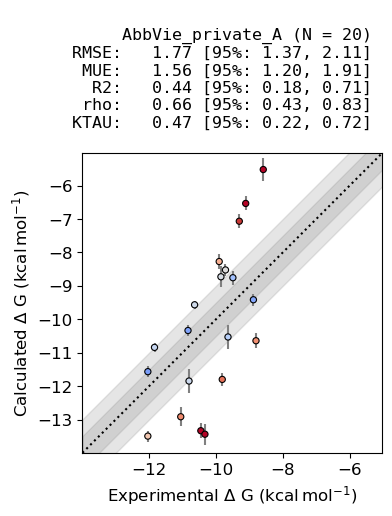

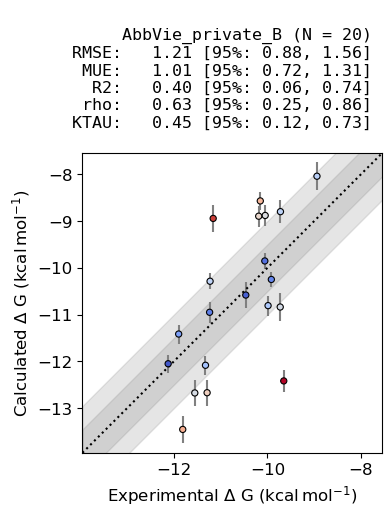

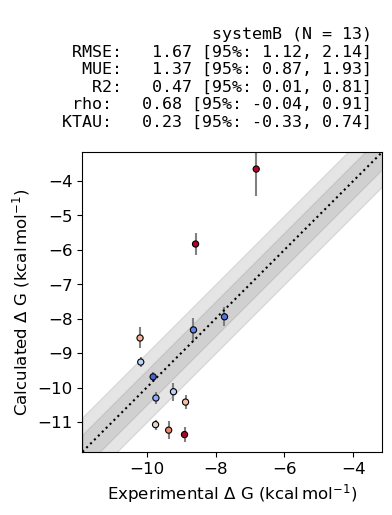

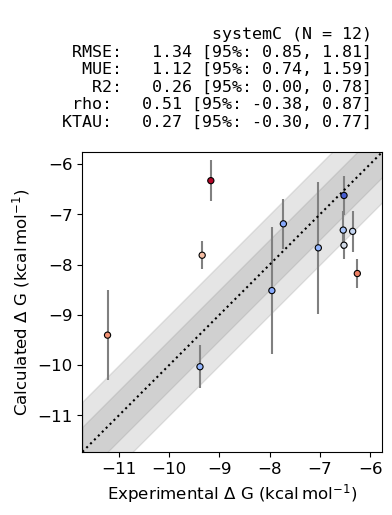

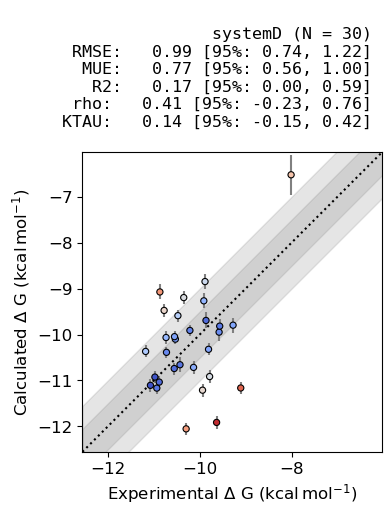

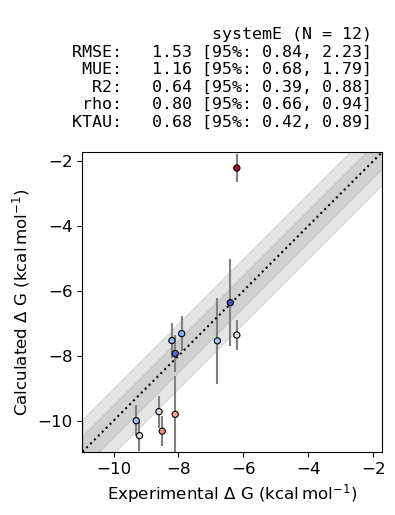

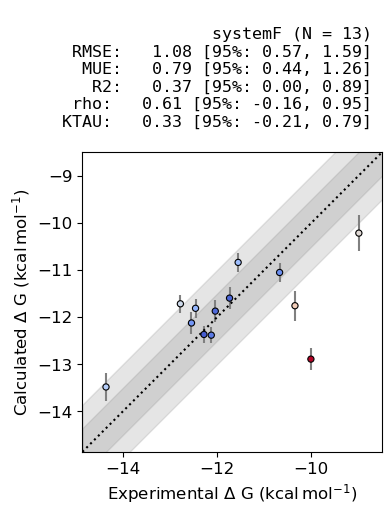

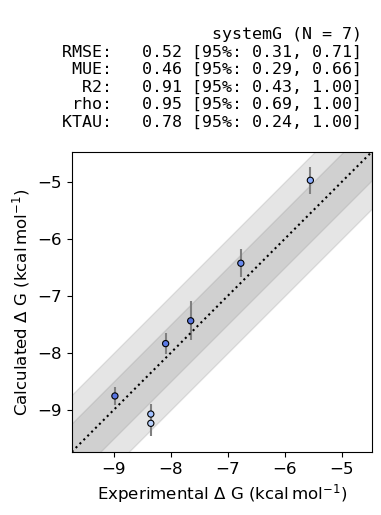

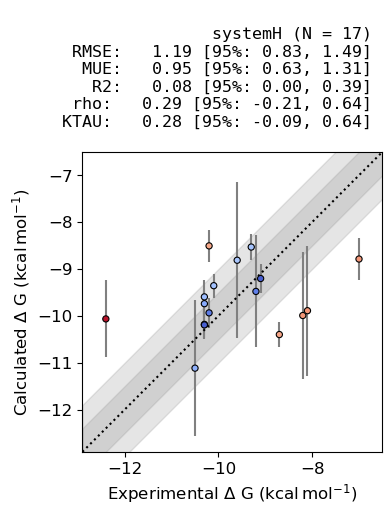

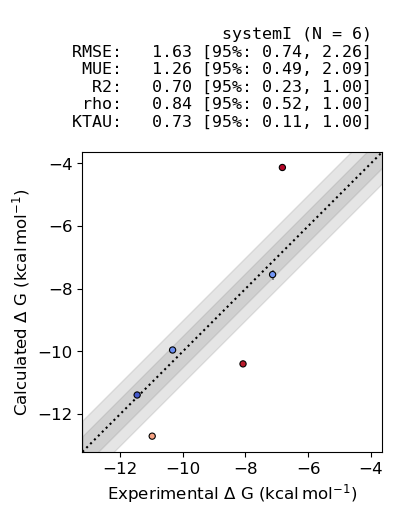

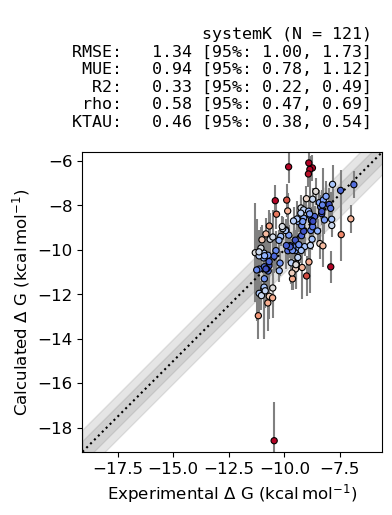

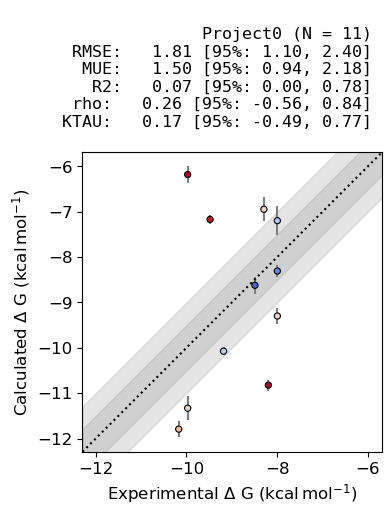

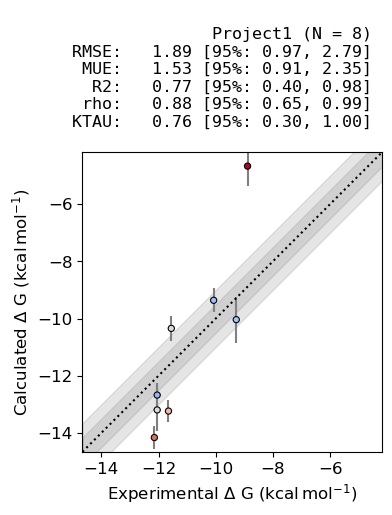

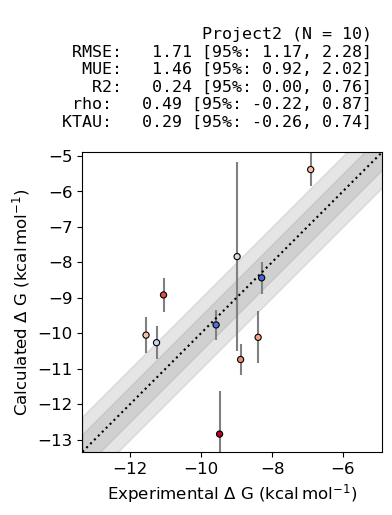

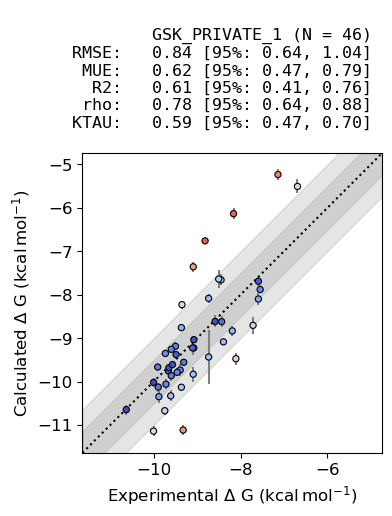

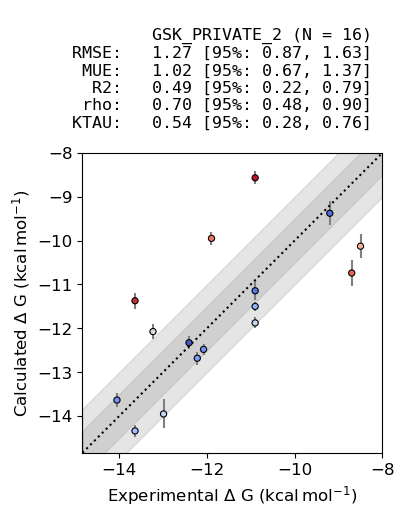

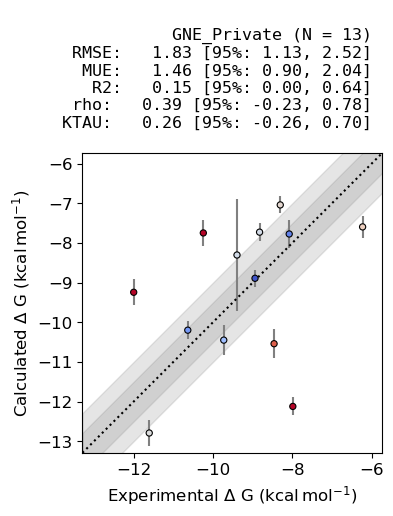

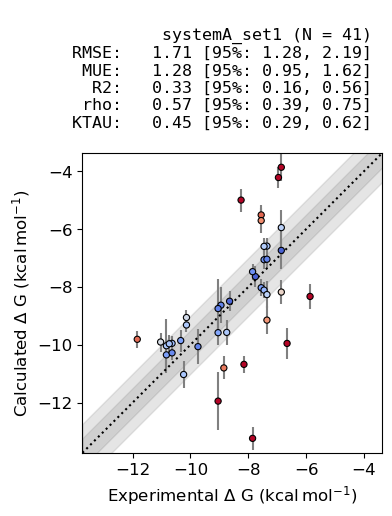

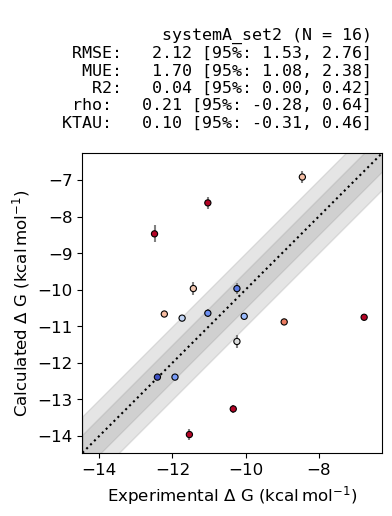

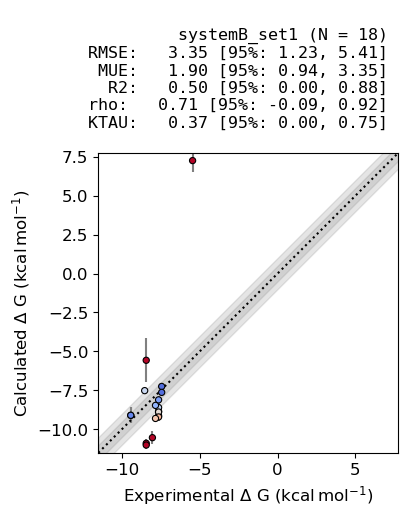

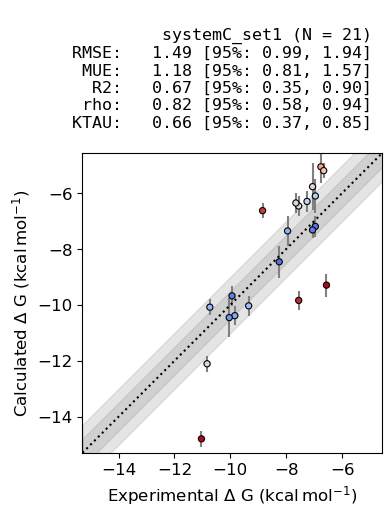

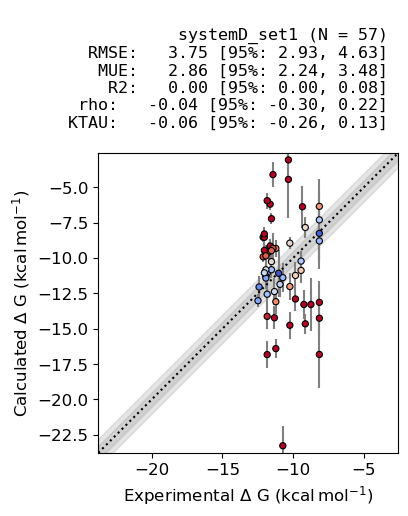

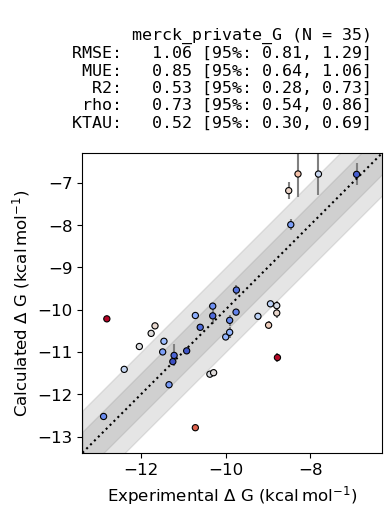

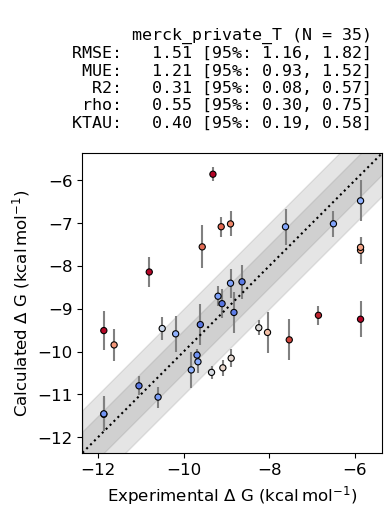

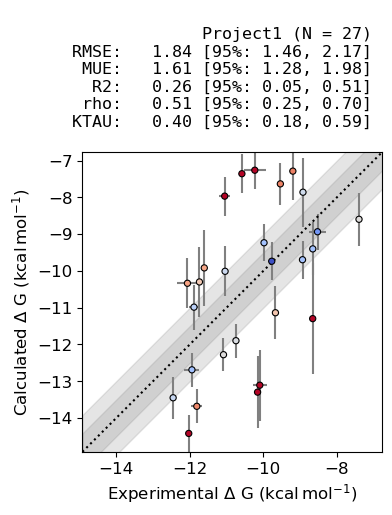

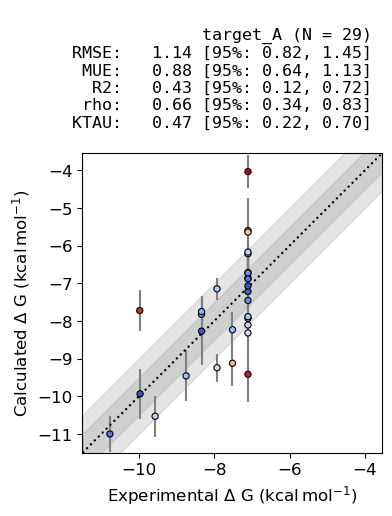

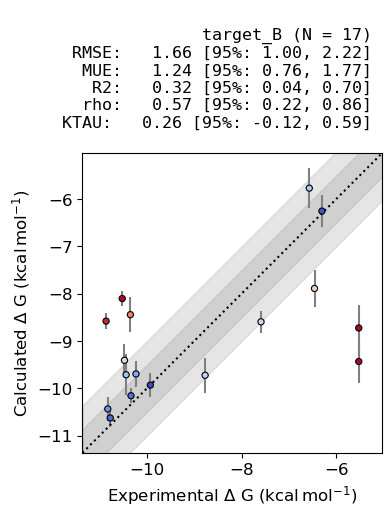

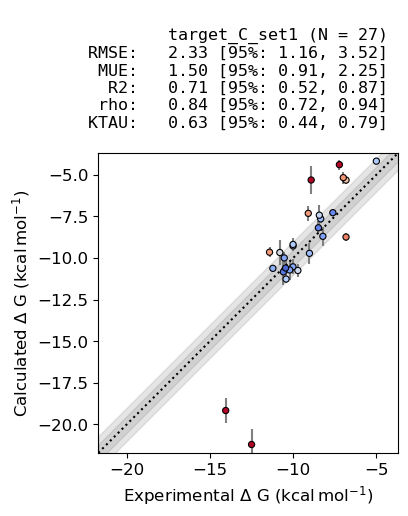

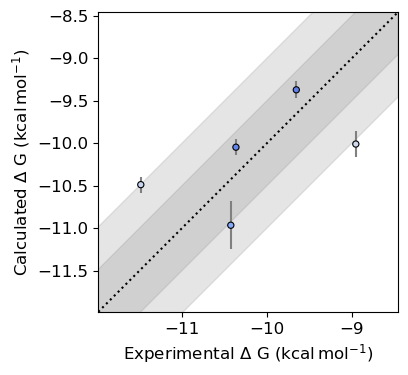

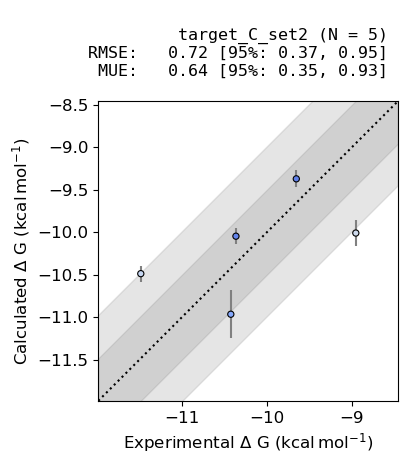

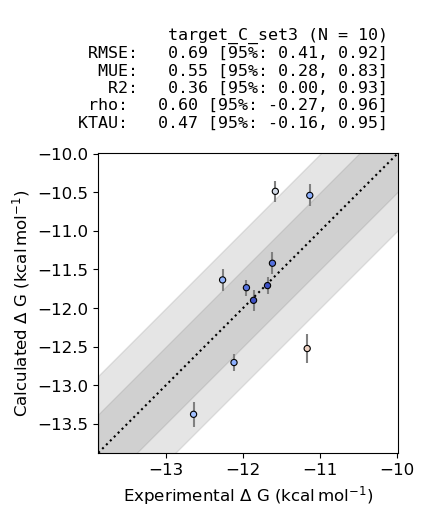

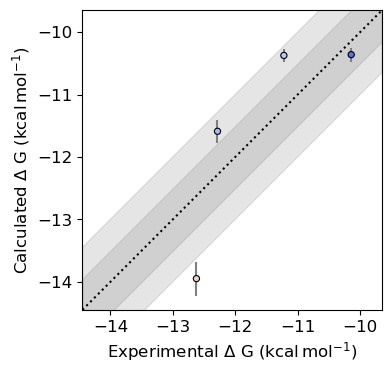

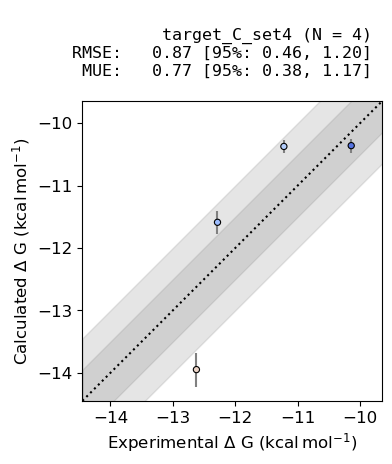

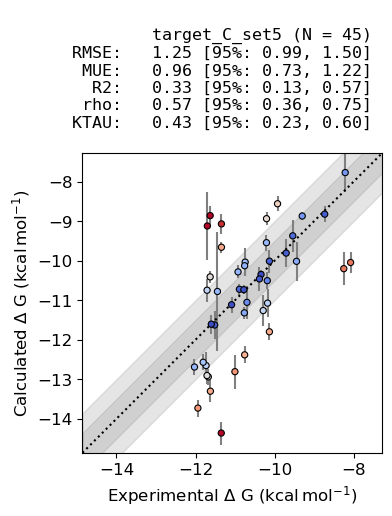

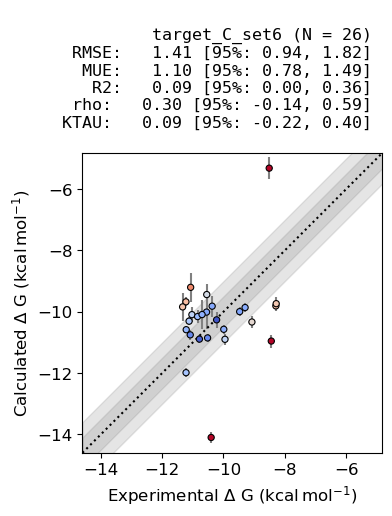

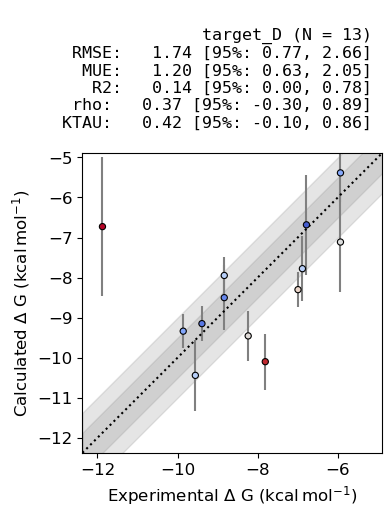

In [23]:
# OpenFE private
dg_plot_per_system(df_private, 'openfe_private')

## Get statistics
This is only calculating statistics for system with at least 16 ligands and a themodynamic range of at least 3 kcal/mol (Hahn et al.).

In [24]:
stats_openfe_public = _get_statistics_dict(df_public)

In [25]:
stats_ross_public = _get_statistics_dict(df_fep_filtered)

In [26]:
stats_openfe_private = _get_statistics_dict(df_private)

In [27]:
rae_openfe = []
rae_fep = []
rmse_openfe = []
rmse_fep = []
mue_openfe = []
mue_fep = []
r2_openfe = []
r2_fep = []
ktau_openfe = []
ktau_fep = []
fbl_openfe = []
fbl_fep = []

for group, data in stats_openfe_public.items():
    for system, statistics in data.items():
        rmse_openfe.append(statistics['RMSE'])
        rmse_fep.append(stats_ross_public[group][system]['RMSE'])
        mue_openfe.append(statistics['MUE'])
        mue_fep.append(stats_ross_public[group][system]['MUE'])
        rae_openfe.append(statistics['RAE'])
        rae_fep.append(stats_ross_public[group][system]['RAE'])
        fbl_openfe.append(statistics['FBL'])
        fbl_fep.append(stats_ross_public[group][system]['FBL'])
        r2_openfe.append(statistics['R2'])
        r2_fep.append(stats_ross_public[group][system]['R2'])
        ktau_openfe.append(statistics['KTAU'])
        ktau_fep.append(stats_ross_public[group][system]['KTAU'])

In [28]:
from statannotations.Annotator import Annotator

# Get pairs for significance testing
pairs = [
    [('RAE\n[kcal/mol]', 'OpenFE'), ('RAE\n[kcal/mol]', 'FEP+')],
    [('RMSE\n[kcal/mol]', 'OpenFE'), ('RMSE\n[kcal/mol]', 'FEP+')],
    [('MUE\n[kcal/mol]', 'OpenFE'), ('MUE\n[kcal/mol]', 'FEP+')],
    [('R2', 'OpenFE'), ('R2', 'FEP+')],
    [('Kendall\ntau', 'OpenFE'), ('Kendall\ntau', 'FEP+')],
    [('Fraction of\nbest ligand', 'OpenFE'), ('Fraction of\nbest ligand', 'FEP+')],
]

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RMSE
[kcal/mol]_OpenFE vs. RMSE
[kcal/mol]_FEP+: Wilcoxon test (paired samples), P_val:1.574e-05 Stat=9.000e+00
RAE
[kcal/mol]_OpenFE vs. RAE
[kcal/mol]_FEP+: Wilcoxon test (paired samples), P_val:1.574e-05 Stat=9.000e+00
MUE
[kcal/mol]_OpenFE vs. MUE
[kcal/mol]_FEP+: Wilcoxon test (paired samples), P_val:1.192e-05 Stat=8.000e+00
R2_OpenFE vs. R2_FEP+: Wilcoxon test (paired samples), P_val:2.195e-03 Stat=3.600e+01
Kendall
tau_OpenFE vs. Kendall
tau_FEP+: Wilcoxon test (paired samples), P_val:3.907e-02 Stat=6.300e+01
Fraction of
best ligand_OpenFE vs. Fraction of
best ligand_FEP+: Wilcoxon test (paired samples), P_val:2.479e-01 Stat=9.000e+01


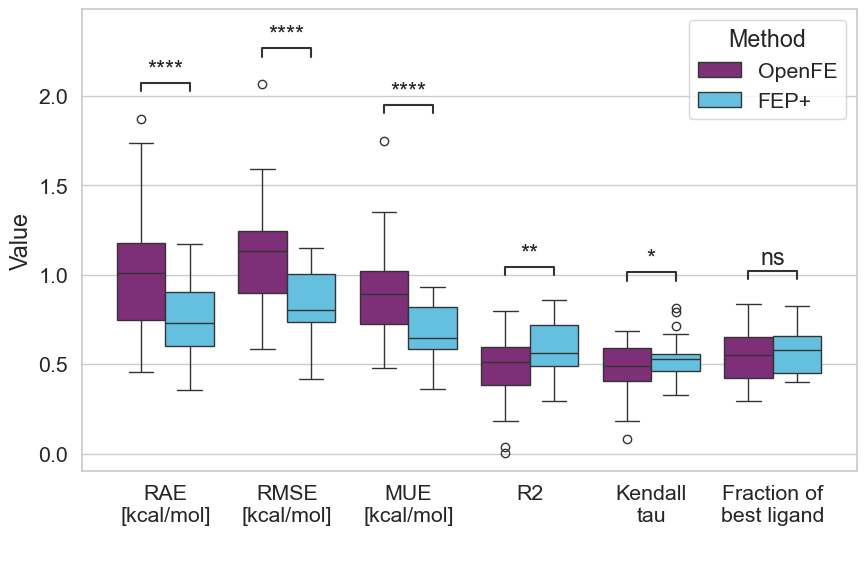

In [36]:
import seaborn as sns
sns.set_style("whitegrid")
# Generate multiple datasets
data = {
    ' ': ['RAE\n[kcal/mol]']*len(rae_openfe+rae_fep) +['RMSE\n[kcal/mol]']*len(rmse_openfe+rmse_fep) +['MUE\n[kcal/mol]']*len(mue_openfe+mue_fep)+ ['R2']*len(r2_fep+r2_openfe) + ['Kendall\ntau']*len(ktau_fep+ktau_openfe)+ ['Fraction of\nbest ligand']*len(fbl_fep+fbl_openfe),
    'Value': rae_openfe+rae_fep +rmse_openfe+rmse_fep +mue_openfe+mue_fep+ r2_openfe+r2_fep + ktau_openfe+ktau_fep+ fbl_openfe+fbl_fep,
    'Method': (['OpenFE']*len(rae_openfe) + ['FEP+']*len(rae_fep) +['OpenFE']*len(rmse_openfe) + ['FEP+']*len(rmse_fep) +['OpenFE']*len(mue_openfe) + ['FEP+']*len(mue_fep)+ ['OpenFE']*len(r2_openfe) + ['FEP+']*len(r2_fep) + ['OpenFE']*len(ktau_openfe) + ['FEP+']*len(ktau_fep)+ ['OpenFE']*len(fbl_openfe) + ['FEP+']*len(fbl_fep))
}
df_box = pd.DataFrame(data)


hue_plot_params = {
    'data': df_box,
    'x': ' ',
    'y': 'Value',
    "hue": "Method",
    "palette": ('#8A2283', '#50CAF5')
}

with sns.plotting_context("notebook", font_scale = 1.4):
    # # Create new plot
    fig, ax = plt.subplots(1, 1, figsize=(10,6))
    # Plot with seaborn
    ax = sns.boxplot(ax=ax, **hue_plot_params)

    # Add annotations
    annotator = Annotator(ax, pairs, **hue_plot_params)
    annotator.configure(test="Wilcoxon").apply_and_annotate()

    # Label and show
    plt.savefig('stats_comparison_openfe_fep+.png', dpi=300, bbox_inches='tight')
    plt.show()

In [30]:
# For the private dataset
rae_openfe_private = []
rmse_openfe_private = []
r2_openfe_private = []
ktau_openfe_private = []
fbl_openfe_private = []
mue_openfe_private = []

for group, data in stats_openfe_private.items():
    for system, statistics in data.items():
        rmse_openfe_private.append(statistics['RMSE'])
        rae_openfe_private.append(statistics['RAE'])
        mue_openfe_private.append(statistics['MUE'])
        fbl_openfe_private.append(statistics['FBL'])
        r2_openfe_private.append(statistics['R2'])
        ktau_openfe_private.append(statistics['KTAU'])

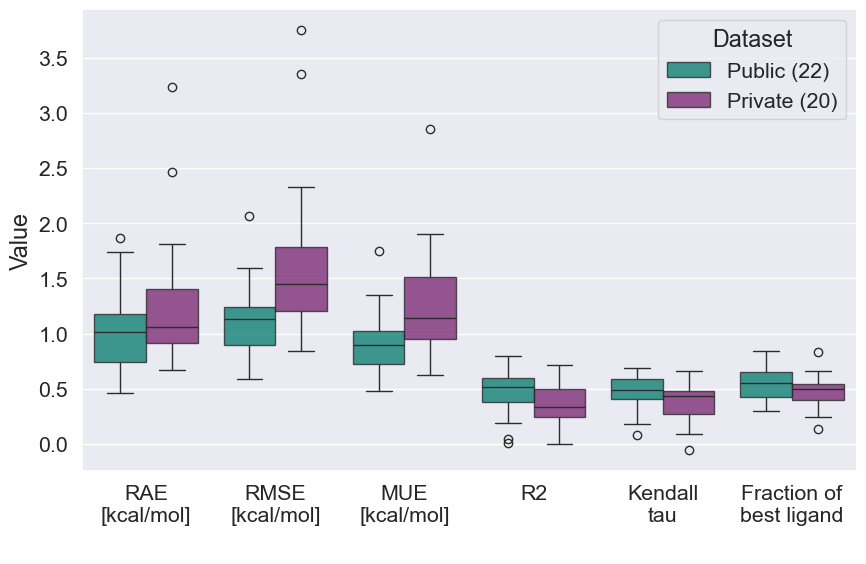

In [31]:
data = {
    ' ': ['RAE\n[kcal/mol]']*len(rae_openfe+rae_openfe_private) +['RMSE\n[kcal/mol]']*len(rmse_openfe+rmse_openfe_private) +['MUE\n[kcal/mol]']*len(mue_openfe+mue_openfe_private)+ ['R2']*len(r2_openfe_private+r2_openfe) + ['Kendall\ntau']*len(ktau_openfe_private+ktau_openfe)+ ['Fraction of\nbest ligand']*len(fbl_openfe_private+fbl_openfe),
    'Value': rae_openfe+rae_openfe_private +rmse_openfe+rmse_openfe_private +mue_openfe+mue_openfe_private+ r2_openfe+r2_openfe_private + ktau_openfe+ktau_openfe_private+ fbl_openfe+fbl_openfe_private,
    'Dataset': ([f'Public ({len(rae_openfe)})']*len(rae_openfe) + [f'Private ({len(rae_openfe_private)})']*len(rae_openfe_private) +[f'Public ({len(rae_openfe)})']*len(rmse_openfe) + [f'Private ({len(rae_openfe_private)})']*len(rmse_openfe_private) +[f'Public ({len(rae_openfe)})']*len(mue_openfe) + [f'Private ({len(rae_openfe_private)})']*len(mue_openfe_private)+ [f'Public ({len(rae_openfe)})']*len(r2_openfe) + [f'Private ({len(rae_openfe_private)})']*len(r2_openfe_private) + [f'Public ({len(rae_openfe)})']*len(ktau_openfe) + [f'Private ({len(rae_openfe_private)})']*len(ktau_openfe_private)+ [f'Public ({len(rae_openfe)})']*len(fbl_openfe) + [f'Private ({len(rae_openfe_private)})']*len(fbl_openfe_private))
}
df_box = pd.DataFrame(data)

hue_plot_params = {
    'data': df_box,
    'x': ' ',
    'y': 'Value',
    # "order": subcat_order,
    "hue": "Dataset",
    "palette": ('#8A2283','#8A2283')
}

with sns.plotting_context("notebook", font_scale = 1.4):
    # # Create new plot
    # ax = get_log_ax()
    fig, ax = plt.subplots(1, 1, figsize=(10,6))
    # Plot with seaborn
    ax = sns.boxplot(ax=ax, **hue_plot_params, boxprops=dict(alpha=.8))

    plt.savefig('stats_comparison_private_public.png', dpi=300, bbox_inches='tight')
    plt.show()

In [32]:
ligands_public, dynamic_range_public = get_ligand_number_dynamic_range(df_public)
ligands_private, dynamic_range_private = get_ligand_number_dynamic_range(df_private)

1.510000228881836
1.7800006866455078
1.3699999999999992
3.010000228881836
2.4099998474121076
1.8900003433227557
1.7999992370605487
2.529999732971193
1.549999713897705
4.089999675750732
5.869999885559082
4.170000076293945
2.140000343322754
1.6600003242492676
3.624962329864502
2.728494167327881
5.86999988555908
1.3499999046325684
3.450000286102295
2.3600001335144043
2.1299996376037598
3.497000217437746
4.210000038146973
3.390000343322752
4.179999828000001
3.780000686645508
5.130000114440918
1.7000002861022931
4.279999732971191
2.499999523162842
4.7885055541992205
4.894043445587158
0.8800001144409197
7.455455303192139
4.983867168426512
4.250016212463379
6.107898712158203
3.5081186294555664
4.559889793395996
4.315285682678223
4.126755714416504
4.292095184326172
3.716984272003172
3.83689498901367
1.5699548721313494
5.301540374755859
3.3557024
1.3353395462036115
0.6400003433227539
0.869999885559082
2.570000171661377
4.564868927001953
3.8799996376037598
4.640000343322754
6.150131225585941
2.3

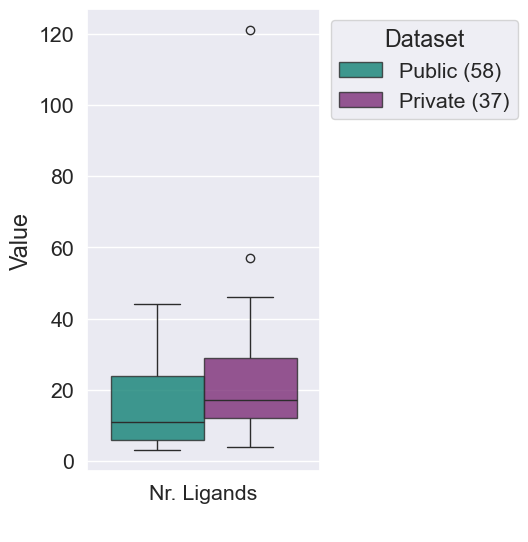

In [33]:
data = {
    ' ': ['Nr. Ligands']*len(ligands_public+ligands_private),
    'Value': ligands_public+ligands_private,
    'Dataset': ([f'Public ({len(ligands_public)})']*len(ligands_public) + [f'Private ({len(ligands_private)})']*len(ligands_private) )
}
df_box = pd.DataFrame(data)

hue_plot_params = {
    'data': df_box,
    'x': ' ',
    'y': 'Value',
    # "order": subcat_order,
    "hue": "Dataset",
    "palette": ('#009384','#8A2283')
}

with sns.plotting_context("notebook", font_scale = 1.4):
    # # Create new plot
    # ax = get_log_ax()
    fig, ax = plt.subplots(1, 1, figsize=(3,6))
    # Plot with seaborn
    ax = sns.boxplot(ax=ax, **hue_plot_params, boxprops=dict(alpha=.8))
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.savefig('nr_ligands_private_public.png', dpi=300, bbox_inches='tight')
    plt.show()

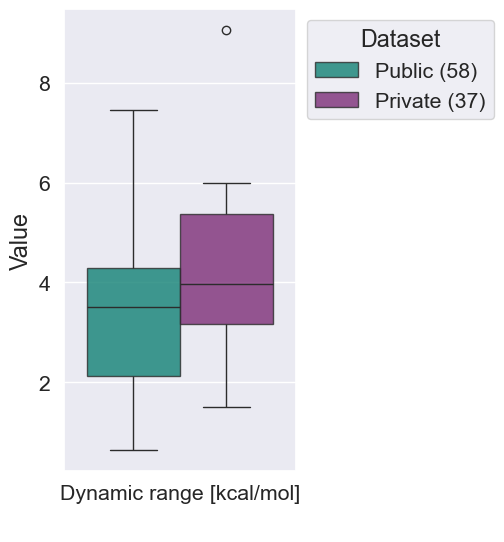

In [34]:
data = {
    ' ': ['Dynamic range [kcal/mol]']*len(dynamic_range_public+dynamic_range_private),
    'Value': dynamic_range_public+dynamic_range_private,
    'Dataset': ([f'Public ({len(ligands_public)})']*len(ligands_public) + [f'Private ({len(ligands_private)})']*len(ligands_private))
}
df_box = pd.DataFrame(data)

hue_plot_params = {
    'data': df_box,
    'x': ' ',
    'y': 'Value',
    # "order": subcat_order,
    "hue": "Dataset",
    "palette": ('#009384','#8A2283')
}

with sns.plotting_context("notebook", font_scale = 1.4):
    # # Create new plot
    # ax = get_log_ax()
    fig, ax = plt.subplots(1, 1, figsize=(3,6))
    # Plot with seaborn
    ax = sns.boxplot(ax=ax, **hue_plot_params, boxprops=dict(alpha=.8))
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

    plt.savefig('dynamic_range_private_public.png', dpi=300, bbox_inches='tight')
    plt.show()